In [1]:
import pandas as pd
import numpy as np
import os
from pathlib import Path
import re
from util import load_metric
from scipy.stats import spearmanr, pearsonr, zscore, rankdata
import matplotlib.pyplot as plt

#from collections import Counter

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_area pre {white-space: pre;}</style>"))

In [3]:
pd.set_option('display.expand_frame_repr', False)

In [4]:
pd.set_option('display.max_columns', None)

## FUNCTIONS

### Utils

In [5]:
def jaccard(a, b):
    return len(a.intersection(b)) / len(a.union(b))

In [6]:
def v_renamer(var_string):
    var_string = var_string.split("_")
    yi, yj     = tuple(var_string[-1].split(":"))
    yi         = yi[-2:]
    yj         = yj[-2:]
    return f"{yi}:{yj}"

In [7]:
def read_csv(path):
    return pd.read_csv(path, sep=";", index_col=0)

In [8]:
def get_dwts(df, path):
    with open(Path(path), "r") as f:
        dwt_roots = [w.strip("\n") for w in f.readlines()]
    dwt_regex = re.compile(f"({'|'.join(dwt_roots)})")    
    dwts = [str(w) for w in df.index if re.search(dwt_regex, str(w)) != None]
    return dwts    

In [9]:
def get_variables(df):
    """
    Summeraises variables of a dataframe
    """
    
    yr_prefix = set()
    tr_prefix = set()
    years = set()
    transitions = set()
    
    for v in df.columns:
        prefix, suffix = tuple(v.split("_"))
        if ":" in suffix:
            tr_prefix.add(prefix)
            transitions.add(suffix)
        else:
            yr_prefix.add(prefix)
            years.add(suffix)
    
    return {
        "yr_prefix": yr_prefix, 
        "tr_prefix": tr_prefix,
        "years": years,
        "transitions": transitions
        }    

In [10]:
def find_transitions(source, mode="file", var = None):
    """
    List transitions. 
    For mode = "file", expected source: filepath
    For mode = "df", expected source: pandas DataFrame; provide varible var
    """
    if mode == "file":
        years = [int(file.strip(".txt")) for file in os.listdir(source)]
        years.sort()
        transitions = [(year, years[i]) for i, year in enumerate(years[:-1], start=1)]
    if mode == "df":
        cols = [col for col in source.columns if col.startswith(var)]
        cols.sort()
        transitions = [tuple(col.split("_")[-1].split(":")) for col in cols]
    return transitions

In [11]:
def nonaninf(x, y):
    if pd.isna(x):
        return False
    if pd.isna(y):
        return False   
    if abs(x) == np.inf:
        return False
    if abs(y) == np.inf:
        return False
    return True

In [12]:
def nonalist(lst):
    for x in lst:
        if pd.isna(x):
            return False
    return True

### Debugging

In [13]:
def collect_var(df, var, varcut):
    X = []
    varcol = sorted([col for col in df.columns if col.startswith(var)])
    if varcut != None:
        del varcol[varcut]
    for col in varcol:
        X.extend(list(df[col]))
    return X    

In [14]:
def w_overlap_checker(corpus, th_c):
    
    corpus = Path(corpus)
    transitions = find_transitions(corpus / "vocab")
    
    for yi, yj in transitions:
        print()
        print(f"{yi}:{yj}")
        
        voc_a = load_metric(corpus / f"vocab/{yi}.txt")
        voc_b = load_metric(corpus / f"vocab/{yj}.txt")

        voc_a = {w: c for w, c in voc_a.items() if c >= th_c}
        voc_b = {w: c for w, c in voc_b.items() if c >= th_c}
        print(f"{yi}:", len(voc_a))
        print(f"{yj}:", len(voc_b))
        print(f"{yi} and {yj}:", len([w for w in voc_a.keys() if w in voc_b.keys()]))
        print(f"{yi} or {yj}:", len(set(voc_a.keys()).union(set(voc_b.keys()))))
        print(f"{yi} - {yj}:", len(set(voc_a.keys()).difference(set(voc_b.keys()))))

In [15]:
def checker(word, transition, controls_dir, n_ctrl=10, variable="cosine_change"):
    """
    Goes to original data, shows the control change/similarity of a word 
    at a transition.
    param word
    param transition    tupple of ti and tj 
    param controls_dir  where to find controls
    param variable      "cosine_change" or "cosine_sim"
    """
    
    ti, tj = transition
    basename = Path(controls_dir) / variable 
    
    filenames = [f"{ti}_{tj}_control{n}.txt" for n in range(1, n_ctrl+1)]
    
    values = []
    
    for file in filenames:
        data = load_metric(basename / file)
        value = data[word] if word in data else "NO MEASURE"
        values.append(value)
        print(file, value)
        
    return values   

In [16]:
def ncd(DATA, CORPUS, VAR, VAL): # No Change Detector

    corpus = Path(CORPUS)
    transitions = find_transitions(corpus / "vocab")    

    for yi, yj in transitions:
        print()
        print(f"{yi}:{yj}")
        
        A = list(DATA[DATA[f"{VAR}_{yi}:{yj}"] == VAL].index)
        print("No change (A):", len(A))
        B = list(DATA[DATA[f"{VAR}_{yi}:{yj}"] != VAL].index)
        print("Other (B):", len(B))
        print()
        print("{: <20} {}".format("A", "B"))
        print("{: <20} {}".format("---", "---"))
        for w1, w2 in zip(A[:100], B[:100]):
            print(f"{w1: <20} {w2}")

### Main functions

In [17]:
def q_show(df, var, k = 40, as_table = False, transition=True, min_freq=None, return_md=False):
    """
    Given a dataframe, shows the top k words for variable var each year.
    Note: as_table only sypported for transition variables!
    """
    
    COLUMNS = [col for col in sorted(df.columns) if col.startswith(var)]

    if min_freq == None:    
        WORDS = [df[col].sort_values(ascending=False)[:k].index for col in COLUMNS]
    else:
        TRANSITIONS = [tuple(col.split("_")[-1].split(":")) for col in COLUMNS]
        WORDS = [df[(df[f"frq_{trs[0]}"] >= min_freq) & (df[f"frq_{trs[1]}"] >= min_freq)][col].sort_values(ascending=False)[:k].index for col, trs in zip(COLUMNS, TRANSITIONS)]
    
    ser = [(c, d) for c, d in zip(COLUMNS, WORDS)]
    
    md = ""
    
    for i, (col, s) in enumerate(ser):
        if i > 0:
            jac = round(jaccard(set(s), ser[i-1][-1]), 2)
        else:
            jac = None
        
        print(); md += "\n"
        print(col, "jaccard =", jac); md += f"{col} jaccard = {jac}"

        if transition:
            if as_table == False:
                print(s)
            else:
                trans  = col.split("_")[-1]
                ti, tj = tuple(trans.split(":"))
                table  = [] 
                for word in s:
                    v    = df.loc[word][col]
                    f_ti = int(df.loc[word][f"frq_{ti}"])
                    f_tj = int(df.loc[word][f"frq_{tj}"])
                    gch  = df.loc[word][f"gch_{trans}"]
                    m    = df.loc[word][f"mccc_{trans}"]
                    std  = df.loc[word][f"stdc_{trans}"]
                    columns = ["Word", var.upper(), "n_i", "n_j", "GCH", "Mctrl", "Sctrl"]
                    table.append([word, v, f_ti, f_tj, gch, m, std])
                print(pd.DataFrame(table, columns=columns).dropna().round(3))
                md += pd.DataFrame(table, columns=columns).dropna().round(3).to_markdown()
        
        else:
            year = col.split("_")[-1]
            table = []
            for word in s:
                v    = df.loc[word][col]
                f = int(df.loc[word][f"frq_{year}"])
                columns = ["Word", var.upper(), "Freq"]
                table.append([word, v, f])
            print(pd.DataFrame(table, columns=columns).dropna().round(3))
            md += pd.DataFrame(table, columns=columns).dropna().round(3).to_markdown()
    if return_md:
        return md

In [18]:
def change_show(df, var, targets, th=4.781, return_md = False, min_freq=10):
    """
    Given a dataframe, shows the value for a variable of target 
    each transition/year.
    Provide threshold to only show the targets meeting the threshold
    """
    
    md = ""

    for col in sorted([col for col in df.columns if col.startswith(var)]):
        trans  = col.split("_")[-1]
        ti, tj = tuple(trans.split(":"))
        table  = [] 
        
        for word in targets:
            v    = df.loc[word][col]
            f_ti = int(df.loc[word][f"frq_{ti}"])
            f_tj = int(df.loc[word][f"frq_{tj}"])
            if min_freq != None:
                if f_ti < min_freq or f_tj < min_freq:
                    continue
            gch  = df.loc[word][f"gch_{trans}"]
            m    = df.loc[word][f"mccc_{trans}"]
            std  = df.loc[word][f"stdc_{trans}"]            
            
            if th != None:
                if v > th:
                    table.append([word, v, f_ti, f_tj, gch, m, std])
            else:
                table.append([word, v, f_ti, f_tj, gch, m, std])
        
        columns = ["Word", "Value", f"n_{ti}", f"n_{tj}", f"gch_{ti}:{tj}", f"M_{ti}:{tj}", f"Std_{ti}:{tj}"]
        if table != []:
            display = pd.DataFrame(table, columns=columns)
            print(); md += "\n" 
            print(col); md += f"{col}\n"
            print(display); md += display.to_markdown()
    
    if return_md:
        return md

In [19]:
def overview(
    df, 
    var, 
    targets, 
    prefixes = ("N", "A", "V"), 
    th=4.781, 
    transition = True, 
    min_freq = 10, 
    return_md = False,
    rounder = 3
):
    """ 
    Similar to change_show but:
    * Show data as one table
    * Only show variable (change_show display additional data)
    * Provide th to show True/False
    """
    
    cols = sorted([col for col in df.columns if col.startswith(var)])
    targets = [w for w in targets if w.startswith(prefixes)]
    targets.sort()
    if transition:
        renamer = {k: v_renamer(k) for k in cols}
    else:
        renamer = {k: k.split("_")[-1][-2:] for k in cols}
    
    md = ""
    
    if min_freq != None and transition:
        df = df.copy()
        transitions = find_transitions(df, "df", var)
        for trg in targets:
            for ti, tj in transitions:
                if df.loc[trg][f"frq_{ti}"] < min_freq or df.loc[trg][f"frq_{tj}"] < min_freq:
                    #df.at[trg, f"{var}_{ti}:{tj}"] = 0
                    df.at[trg, f"{var}_{ti}:{tj}"] = np.nan

    if min_freq != None and transition == False:
        df = df.copy()
        years = sorted([int(col.split("_")[-1]) for col in cols])
        for trg in targets:
            for year in years:
                if df.loc[trg][f"frq_{year}"] < min_freq:
                    df.at[trg, f"{var}_{year}"] = 0        
                       
    
    if th != None:
        #print(df.loc[targets, cols])
        out = df.loc[targets, cols] > th
        out.rename(columns = renamer, inplace = True)
        print(var.upper()); md += var.upper() + "\n"
        print(out); md += out.to_markdown()
        print("SUM:", out.sum().sum()); md += f"\nSUM: {out.sum().sum()}\n"
    else:
        out = df.loc[targets, cols].round(rounder)
        out.rename(columns = renamer, inplace = True)
        print(var.upper()); md += var.upper() + "\n"
        print(out); md += out.to_markdown()
        print("SUM:", out.sum().sum()); md += f"\nSUM: {out.sum().sum()}\n"
    
    if return_md:
        return md
    else: 
        return out

In [20]:
def trend(df, var, norm=None, transition = True, metric="pearson", prefixes = ("N", "A", "V")):
    
    if transition:
        T = find_transitions(source=df, mode = "df", var=var)
    else:
        cols = [col for col in df.columns if col.startswith(var)]
        cols.sort()
        T = [int(col.split("_")[-1]) for col in cols]

    Y = [n for n in range(len(T))]
    table = []
    for w in df.index:
        
        if prefixes != None:
            if not w.startswith(prefixes):
                continue
        
        if transition:
            X = df[[f"{var}_{ti}:{tj}" for ti, tj in T]].loc[w]
        else:
            X = df[[f"{var}_{t}" for t in T]].loc[w]
        
        
        valid = [(x, y) for x, y in zip(X, Y) if not pd.isna(x)]

        N = len(valid)

        if N < 2:
            v = np.nan
            p = np.nan
        else:
            X, Y = zip(*valid)
            if norm != None:
                X = norm(X)

            if metric == "pearson":
                R_data = pearsonr(X, Y)

            if metric == "spearman":
                R_data = spearmanr(X, Y)
                
            v = R_data.statistic
            p = R_data.pvalue

        table.append([w, round(v, 3), round(p, 5), N])
    correlation = pd.DataFrame(table, columns=["Word", "Trend", "p", "N"])
        
    return correlation
    

In [189]:
def correlation(
    df, 
    var1,
    var2, 
    mode=1,
    varcutter=False, # Cuts var1
    prenorm1 = None,
    prenorm2 = None,
    norm1=None, 
    norm2=None, 
    metric="pearson"
):    
    """
    
    ...
    param norm1  function to normalize/transform var1 with (default None); provide function 
                 e.g. zscore or np.log 
    """

    transitions1 = find_transitions(df, "df", var1)
    transitions2 = find_transitions(df, "df", var2)

    if mode == 1:
        correlation = df[[f"{var1}_{ti}:{tj}" for ti, tj in transitions]].corrwith(df[[f"{var2}_{ti}:{tj}" for ti, tj in transitions]], axis=1)
    
    if mode == 2:
        table = []
        for w in df.index:
            valid = []
            if varcutter:
                X = df[[f"{var1}_{t[0]}" for t in transitions1]].loc[w]
                #print(X)
                X = X[1:]
            else:
                X = df[[f"{var1}_{ti}:{tj}" for ti, tj in transitions1]].loc[w]
                
            Y = df[[f"{var2}_{ti}:{tj}" for ti, tj in transitions2]].loc[w]
            for x, y in zip(X, Y):
                if pd.isna(x):
                    continue
                if pd.isna(y):
                    continue
                valid.append((x, y))
            
            N = len(valid)
            
            if N < 2:
                v = np.nan
                p = np.nan
            else:
                X, Y = zip(*valid)
                
                if prenorm1 != None:
                    X = prenorm1(X)
                if prenorm2 != None:
                    Y = prenorm2(Y)                
                
                if norm1 != None:
                    X = norm1(X)
                if norm2 != None:
                    Y = norm2(Y)
                    
                X, Y = zip(*[(x, y) for x, y in zip(X, Y) if nonaninf(x,y)])

                if metric == "pearson":
                    R_data = pearsonr(X, Y)
                    v = R_data.statistic
                    p = R_data.pvalue

                if metric == "spearman":
                    R_data = spearmanr(X, Y)
                    v = R_data.statistic
                    p = R_data.pvalue
                    
            table.append([w, round(v, 2), round(p, 2), N])
        correlation = pd.DataFrame(table, columns=["Word", "Correlation", "p", "N"])
        
    return correlation

In [22]:
def universal_correlation(
    df, 
    var1, 
    var2, 
    var1cut = None, 
    var2cut = None,
    prenorm1 = None,
    prenorm2 = None,
    norm1=None, 
    norm2=None, 
    metric="pearson",
    top_n = None,
    min_freq = None
):
    # https://stackoverflow.com/questions/16031056/how-to-form-tuple-column-from-two-columns-in-pandas
    
    if top_n != None:
        df = df.copy()
        df = df.sort_values(by=['tot_frq'], ascending=False)[:top_n]
        #print(df)
    
    if min_freq != None:
        df = df.copy()
        
        t1 = find_transitions(df, "df", var1)
        t2 = find_transitions(df, "df", var2)
        
        if var1cut != None:
            transitions = [t for t in t2]
            print("transitions", transitions)
        else:
            transitions = [t for t in t1]
        

        for trg in [w for w in df.index]:
            for ti, tj in transitions:
                if df.loc[trg][f"frq_{ti}"] < min_freq or df.loc[trg][f"frq_{tj}"] < min_freq:
                    df.at[trg, f"{var2}_{ti}:{tj}"] = np.nan
    
    X = collect_var(df, var1, var1cut)
    Y = collect_var(df, var2, var2cut)
            
    print("Length:")
    print("X:", len(X))
    print("Y:", len(Y))
    
    X, Y = zip(*[(x, y) for x, y in zip(X, Y) if nonaninf(x,y)])

    if prenorm1 != None:
        X = prenorm1(X)
    if prenorm2 != None:
        Y = prenorm2(Y)    
    
    if norm1 != None:
        X = norm1(X)
    if norm2 != None:
        Y = norm2(Y)
    
    if metric == "pearson":
        R_data = pearsonr(X, Y)
    if metric == "spearman":
        R_data = spearmanr(X, Y)
        
    v = R_data.statistic
    p = R_data.pvalue
    
    return v, p

In [23]:
def model_comparison(
    dfs,
    mnames,
    var,
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="universal", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=None, # A list of the same length as dfs and mnames
    word=None, # not supported at the moment ... 
    metric="pearson",
):

    trgs = [trg for trg in get_dwts(dfs[0], targets)]             # based on first df
    trgs = [trg for trg in trgs if trg.startswith(prefix)] if prefix != None else trgs
    print("Targets:", ", ".join(trgs))    
    
    _XY = []
    if mode == "universal":
        cols = [col for col in dfs[0].columns if col.startswith(var)] # based on first df
        
        for model, mname in zip(dfs, mnames):
            this_model = []
            for col in cols:
                this_model.extend(model.loc[trgs, col])
            print("Length", mname, len(this_model))
            _XY.append(this_model)
    
    if mode == "var_off":
        for model, mname, voff in zip(dfs, mnames, var_off):
            
            cols = [col for col in model.columns if col.startswith(voff)]
            
            this_model = []
            for col in cols:
                this_model.extend(model.loc[trgs, col])
            print("Length", mname, len(this_model))
            _XY.append(this_model)        
    
    _XY = list(zip(*[xyz for xyz in zip(*_XY) if nonalist(xyz)])) # note: xyz is a variable for a tuple
    
    print("Length (no NaN):")
    for vector in _XY:
        print(len(vector))
    
    _XY = [norm(model) for model in _XY] if norm != None else _XY
    
    if metric == "pearson":
        R_data = np.corrcoef(_XY)
    if metric == "spearman": # Perhaps recommended for mode = "var_off"?
        _XY = [rankdata(model) for model in _XY]
        R_data = np.corrcoef(_XY)
        
    out = pd.DataFrame(R_data, columns=mnames, index=mnames).round(3)

    return out

### Visualization

In [24]:
def vis_u_cor(
    df, 
    var1, 
    var2, 
    var1cut = None, 
    var2cut = None, 
    norm1=None, 
    norm2=None, 
    top_n = None,
    min_freq = None
):
    # https://stackoverflow.com/questions/16031056/how-to-form-tuple-column-from-two-columns-in-pandas
    
    if top_n != None:
        df = df.copy()
        df = df.sort_values(by=['tot_frq'], ascending=False)[:top_n]
        #print(df)
    
    if min_freq != None:
        df = df.copy()
        
        t1 = find_transitions(df, "df", var1)
        t2 = find_transitions(df, "df", var2)
        
        if var1cut != None:
            transitions = [t for t in t2]
            print("transitions", transitions)
        else:
            transitions = [t for t in t1]
        

        for trg in [w for w in df.index]:
            for ti, tj in transitions:
                if df.loc[trg][f"frq_{ti}"] < min_freq or df.loc[trg][f"frq_{tj}"] < min_freq:
                    df.at[trg, f"{var2}_{ti}:{tj}"] = np.nan
    
    X = collect_var(df, var1, var1cut)
    Y = collect_var(df, var2, var2cut)
            
    print("Length:")
    print("X:", len(X))
    print("Y:", len(Y))
    
    X, Y = zip(*[(x, y) for x, y in zip(X, Y) if nonaninf(x,y)])
        
    if norm1 != None:
        X = norm1(X)
    if norm2 != None:
        Y = norm2(Y)
    
    plt.scatter(X, Y)
    plt.show()    

In [25]:
def vis_cor(
    df, 
    var1, 
    var2, 
    var1tr = True, 
    var2tr = True, 
    prenorm1 = None,
    prenorm2 = None,
    norm1=None, 
    norm2=None
):    
    """
    
    ...
    param norm1  function to normalize/transform var1 with (default None); provide function 
                 e.g. zscore or np.log 
    """

    tr1 = find_transitions(df, "df", var1)
    if var1tr == False:
        tr1 = [f"{var1}_{tr[0]}" for tr in tr1] # Note choses 1st ## VAR CUT!
    else:
        tr1 = [f"{var1}_{ti}:{tj}" for ti, tj in tr1]
    
    tr2 = find_transitions(df, "df", var2)
    if var2tr == False:
        tr2 = [f"{var2}_{tr[0]}" for tr in tr2]
    else:
        tr2 = [f"{var2}_{ti}:{tj}" for ti, tj in tr2]
    
    for w in df.index:
        print(w)
        valid = []
        transitions = []
        X = df[tr1].loc[w]
        Y = df[tr2].loc[w]
        for x, y, transition in zip(X, Y, tr1):
            if pd.isna(x):
                continue
            if pd.isna(y):
                continue
            valid.append((x, y))
            transitions.append(transition)

        N = len(valid)
#         print(valid)
#         print(transitions)

        if N < 2:
            print("Nope ...")
            print()
        else:
            X, Y = zip(*valid)
            
            if prenorm1 != None:
                X = prenorm1(X)
            if prenorm2 != None:
                Y = prenorm2(Y)
                
            if norm1 != None:
                X = norm1(X)
            if norm2 != None:
                Y = norm2(Y)

            #Tx = range(len(X))
            #Ty = range(len(Y))
            T = [int(trans[-4:]) for trans in transitions]

            #plt.plot(Tx, X, Ty, Y, marker = 'o')
            plt.plot(T, X, "-b", label=var1)
            plt.plot(T, Y, "-r", label=var2)
            plt.legend(loc="upper left")
            plt.show()
                

In [26]:
def visualize(df, term, variable, prefix = None, transition = True, norm=None):
    
    transitions = find_transitions(df, "df", variable)
    if transition == False:
        transitions = [x[0] for x in transitions]
    
    cols  = [f"{variable}_{x}" for x in transitions]
    years = [int(x.split("_")[-1]) for x in cols]
    
    if term == "--ALL":
        terms = [w for w in df.index if w.startswith(prefix)] if prefix != None else df.index
        for t in terms:
            print(t.upper())
            Y = []
            for col in cols:
                Y.append(df.loc[t, col])     
    
            plt.plot(years, Y)
            plt.show()
            if transition:
                print("NOTE: Each X is a transition from previous!")
    else:
        print(t.upper())
        Y = []
        for col in cols:
            Y.append(df.loc[term, col])     

        plt.plot(years, Y)
        plt.show()
        if transition:
            print("NOTE: Each X is a transition from previous!")

## FILES

In [27]:
#file_path = Path("../../dw_results/fb_pol-yearly-radical3.csv")
#file_path = Path("fb_pol-yearly-radical3.csv")
results_dir = Path("../../dw_results")

In [28]:
files = sorted(os.listdir(results_dir))
_ = [print(file) for file in files]

bert-v0
change_tables
fb_pol-time_bin-bert-fb_nli.csv
fb_pol-time_bin-bert-sentence-bert-swedish-cased.csv
fb_pol-time_bin-bert-sts_fbmodel.csv
fb_pol-time_bin-bert-sts_fbmodel_big_40epochs.csv
fb_pol-time_bin-radical3-full.csv
fb_pol-time_bin-radical3-restricted.csv
fb_pol-yearly-bert-fb_nli.csv
fb_pol-yearly-bert-sentence-bert-swedish-cased.csv
fb_pol-yearly-bert-sts_fbmodel.csv
fb_pol-yearly-bert-sts_fbmodel_big_40epochs.csv
fb_pol-yearly-cluster-sts_fbmodel.csv
fb_pol-yearly-radical3-full.csv
fb_pol-yearly-radical3-restricted.csv
neighbors


In [29]:
dwt_path = "../data/utils/dwts.txt"

In [30]:
#crp_tib = Path("/srv/data/gusbohom/root/corpora/toypol/time_bin/radical3/")
corpus = Path("/home/max/Corpora/flashback-pol-time/yearly/fb-pt-radical3")

### Yearly

In [31]:
df_yearly = read_csv(results_dir / "fb_pol-yearly-radical3-full.csv")

In [32]:
df_yearly_dwt = read_csv(results_dir / "fb_pol-yearly-radical3-restricted.csv")

In [33]:
df_bert_nli = read_csv(results_dir / "fb_pol-yearly-bert-fb_nli.csv")

In [34]:
df_bert_sts = read_csv(results_dir / "fb_pol-yearly-bert-sts_fbmodel.csv")

In [35]:
df_bert_big = read_csv(results_dir / "fb_pol-yearly-bert-sts_fbmodel_big_40epochs.csv")

In [36]:
df_bert_kb  = read_csv(results_dir / "fb_pol-yearly-bert-sentence-bert-swedish-cased.csv")

### Time bin 

In [37]:
df_tbn = read_csv(results_dir / "fb_pol-time_bin-radical3-full.csv")

In [38]:
df_tbn_dwt = read_csv(results_dir / "fb_pol-time_bin-radical3-restricted.csv")

In [39]:
df_tbn_nli = read_csv(results_dir / "fb_pol-time_bin-bert-fb_nli.csv")

In [40]:
df_tbn_sts = read_csv(results_dir / "fb_pol-time_bin-bert-sts_fbmodel.csv")

In [41]:
df_tbn_big = read_csv(results_dir / "fb_pol-time_bin-bert-sts_fbmodel_big_40epochs.csv")

In [42]:
df_tbn_kb = read_csv(results_dir / "fb_pol-time_bin-bert-sentence-bert-swedish-cased.csv")

### Cluster

In [43]:
df_cluster = read_csv(results_dir / "fb_pol-yearly-cluster-sts_fbmodel.csv")

-----------------

## TRENDS

Most terms increases over time.

In [44]:
trend(df_yearly_dwt, var="frq", norm=None, transition = False, metric="pearson")

,Word,Trend,p,N
0,N1_kulturberikare,0.084,0.70398,23
1,V1_berika,0.454,0.02973,23
2,N1_berikare,0.084,0.70179,23
3,N1_globalist,0.864,0.00000,23
4,V1_kulturberika,0.166,0.44944,23
5,N1_återvandring,0.673,0.00043,23
6,V1_återvandra,0.755,0.00003,23
7,A1_globalistisk,0.892,0.00000,23
8,V1_hjälpa_på_plats,0.489,0.01791,23
9,N1_förortsgäng,0.797,0.00001,23


In [45]:
trend(df_bert_sts, var="frq", norm=None, transition = False, metric="pearson")

,Word,Trend,p,N
0,N1_kulturberikare,0.082,0.70977,23
1,V1_berika,0.473,0.02254,23
2,N1_berikare,0.083,0.70709,23
3,N1_förortsgäng,0.792,0.00001,23
4,V1_kulturberika,0.173,0.43077,23
5,N1C_kulturberikarX,-0.059,0.78918,23
6,N1_återvandring,0.695,0.00023,23
7,A1_globalistisk,0.895,0.00000,23
8,N1_globalist,0.855,0.00000,23
9,V1_återvandra,0.753,0.00003,23


### SGNS

Considering SGNS models, there is a negative trend less semantic change over time (both GCH and RCH) for "N1_berikare". For other terms, this is not so. Considering STS, there is a negative trend for GCH for several terms, but only for "N1_berikare" and "N1_förortsgäng" for RCH. 

In [46]:
trend(df_yearly_dwt, var="gch", norm=None, transition = True, metric="pearson")

,Word,Trend,p,N
0,N1_kulturberikare,-0.052,0.83392,19
1,V1_berika,0.294,0.22106,19
2,N1_berikare,-0.866,0.00013,13
3,N1_globalist,-0.257,0.53853,8
4,V1_kulturberika,-1.000,1.00000,2
5,N1_återvandring,NaN,NaN,0
6,V1_återvandra,NaN,NaN,0
7,A1_globalistisk,NaN,NaN,0
8,V1_hjälpa_på_plats,NaN,NaN,0
9,N1_förortsgäng,NaN,NaN,0


In [47]:
trend(df_yearly_dwt, var="rch", norm=None, transition = True, metric="pearson")

,Word,Trend,p,N
0,N1_kulturberikare,-0.410,0.08140,19
1,V1_berika,-0.197,0.41899,19
2,N1_berikare,-0.805,0.00090,13
3,N1_globalist,-0.183,0.66532,8
4,V1_kulturberika,-1.000,1.00000,2
5,N1_återvandring,NaN,NaN,0
6,V1_återvandra,NaN,NaN,0
7,A1_globalistisk,NaN,NaN,0
8,V1_hjälpa_på_plats,NaN,NaN,0
9,N1_förortsgäng,NaN,NaN,0


### STS

In [48]:
trend(df_bert_sts, var="gch", norm=None, transition = True, metric="pearson")

,Word,Trend,p,N
0,N1_kulturberikare,-0.666,0.00072,22
1,V1_berika,-0.739,0.00009,22
2,N1_berikare,-0.659,0.00158,20
3,N1_förortsgäng,-0.795,0.00117,13
4,V1_kulturberika,-0.895,0.00019,11
5,N1C_kulturberikarX,-0.791,0.06075,6
6,N1_återvandring,NaN,NaN,0
7,A1_globalistisk,NaN,NaN,1
8,N1_globalist,-0.934,0.06613,4
9,V1_återvandra,NaN,NaN,0


In [49]:
trend(df_bert_sts, var="rch", norm=None, transition = True, metric="pearson")

,Word,Trend,p,N
0,N1_kulturberikare,-0.379,0.08176,22
1,V1_berika,-0.010,0.96396,22
2,N1_berikare,-0.513,0.02079,20
3,N1_förortsgäng,-0.664,0.01330,13
4,V1_kulturberika,0.208,0.54032,11
5,N1C_kulturberikarX,-0.183,0.72842,6
6,N1_återvandring,NaN,NaN,0
7,A1_globalistisk,NaN,NaN,1
8,N1_globalist,0.246,0.75423,4
9,V1_återvandra,NaN,NaN,0


## MODEL COMPARISON

* Approach 1, 2, 3
* *GCH* and *RCH* 
* Note param `var_off`

Term differentiation between models ... There is new code for treating compounds with simples. Re-run BERT analysis ... (and results building).

In [50]:
for w in sorted([w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))]):
    print(w)

A1_globalistisk
N1_berikare
N1_förortsgäng
N1_globalist
N1_kulturberikare
N1_återvandring
N2_återvandrare
V1_berika
V1_hjälpa_på_plats
V1_kulturberika
V1_återvandra


In [51]:
for w in sorted([w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))]):
    print(w)

A1_globalistisk
N1C_berikareX
N1C_globalistX
N1C_kulturberikarX
N1C_återvandringsX
N1_berikare
N1_förortsgäng
N1_globalist
N1_kulturberikare
N1_återvandring
N2C_återvandrarX
N2_återvandrare
V1_berika
V1_hjälpa_på_plats
V1_kulturberika
V1_återvandra


### Approach 1 and 2

* Considering GCH and yearly transitions, SGNS is negatively correlated with BERT models
* With RCH, there is positive correlation.
* With RCH, BERT models are less strongly correlated. 
* Considering four year time bins, there is only positive correlation (both GCH and RCH). The correlation for SGNS and BERT is stronger for RCH. 
* As with yearly transitions, BERT models are less correlated with RCH than GCH. However, there are very strong correlations of RCH for BERT models given time bins. The "lessen effect by RCH" is smaller in time bins experiments than yearly experiment. 

#### Yearly

##### Genuine

In [75]:
print(model_comparison(
    dfs=[df_yearly_dwt, df_bert_nli, df_bert_sts, df_bert_big, df_bert_kb],
    mnames=["SGNS", "NLI", "STS", "BIG", "KB"],
    var="gch", 
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="universal", 
    word=None, # not supported at the moment ... 
    metric="pearson"
).to_markdown())

Targets: N1_kulturberikare, V1_berika, N1_berikare, N1_globalist, V1_kulturberika, N1_återvandring, V1_återvandra, A1_globalistisk, V1_hjälpa_på_plats, N1_förortsgäng, N2_återvandrare
Length SGNS 242
Length NLI 242
Length STS 242
Length BIG 242
Length KB 242
Length (no NaN):
154
154
154
154
154
|      |   SGNS |    NLI |    STS |    BIG |     KB |
|:-----|-------:|-------:|-------:|-------:|-------:|
| SGNS |  1     | -0.266 | -0.366 | -0.349 | -0.312 |
| NLI  | -0.266 |  1     |  0.951 |  0.961 |  0.958 |
| STS  | -0.366 |  0.951 |  1     |  0.991 |  0.952 |
| BIG  | -0.349 |  0.961 |  0.991 |  1     |  0.959 |
| KB   | -0.312 |  0.958 |  0.952 |  0.959 |  1     |


##### Rectified

In [53]:
print(model_comparison(
    dfs=[df_yearly_dwt, df_bert_nli, df_bert_sts, df_bert_big, df_bert_kb],
    mnames=["SGNS", "NLI", "STS", "BIG", "KB"],
    var="rch", 
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="universal", # no other mode supported at the moment ...
    word=None, # not supported at the moment ... 
    metric="pearson"
).to_markdown())

Targets: N1_kulturberikare, V1_berika, N1_berikare, N1_globalist, V1_kulturberika, N1_återvandring, V1_återvandra, A1_globalistisk, V1_hjälpa_på_plats, N1_förortsgäng, N2_återvandrare
Length SGNS 242
Length NLI 242
Length STS 242
Length BIG 242
Length KB 242
Length (no NaN):
154
154
154
154
154
|      |   SGNS |   NLI |   STS |   BIG |    KB |
|:-----|-------:|------:|------:|------:|------:|
| SGNS |  1     | 0.431 | 0.551 | 0.505 | 0.447 |
| NLI  |  0.431 | 1     | 0.772 | 0.579 | 0.779 |
| STS  |  0.551 | 0.772 | 1     | 0.877 | 0.801 |
| BIG  |  0.505 | 0.579 | 0.877 | 1     | 0.752 |
| KB   |  0.447 | 0.779 | 0.801 | 0.752 | 1     |


... with Spearman instead (higher correlation).

In [76]:
print(model_comparison(
    dfs=[df_yearly_dwt, df_bert_nli, df_bert_sts, df_bert_big, df_bert_kb],
    mnames=["SGNS", "NLI", "STS", "BIG", "KB"],
    var="rch", 
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="universal", # no other mode supported at the moment ...
    word=None, # not supported at the moment ... 
    metric="spearman"
).to_markdown())

Targets: N1_kulturberikare, V1_berika, N1_berikare, N1_globalist, V1_kulturberika, N1_återvandring, V1_återvandra, A1_globalistisk, V1_hjälpa_på_plats, N1_förortsgäng, N2_återvandrare
Length SGNS 242
Length NLI 242
Length STS 242
Length BIG 242
Length KB 242
Length (no NaN):
154
154
154
154
154
|      |   SGNS |   NLI |   STS |   BIG |    KB |
|:-----|-------:|------:|------:|------:|------:|
| SGNS |  1     | 0.574 | 0.555 | 0.576 | 0.574 |
| NLI  |  0.574 | 1     | 0.87  | 0.888 | 0.837 |
| STS  |  0.555 | 0.87  | 1     | 0.88  | 0.824 |
| BIG  |  0.576 | 0.888 | 0.88  | 1     | 0.835 |
| KB   |  0.574 | 0.837 | 0.824 | 0.835 | 1     |


#### Four year time bins

##### Genuine

In [78]:
print(model_comparison(
    dfs=[df_tbn_dwt, df_tbn_nli, df_tbn_sts, df_tbn_big, df_tbn_kb],
    mnames=["SGNS", "NLI", "STS", "BIG", "KB"],
    var="gch", 
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="universal", # no other mode supported at the moment ...
    word=None, # not supported at the moment ... 
    metric="pearson"
).to_markdown())

Targets: V1_berika, N1_kulturberikare, N1_globalist, V1_kulturberika, N1_berikare, N1_återvandring, A1_globalistisk, V1_återvandra, V1_hjälpa_på_plats, N1_förortsgäng
Length SGNS 40
Length NLI 40
Length STS 40
Length BIG 40
Length KB 40
Length (no NaN):
36
36
36
36
36
|      |   SGNS |   NLI |   STS |   BIG |    KB |
|:-----|-------:|------:|------:|------:|------:|
| SGNS |  1     | 0.598 | 0.557 | 0.57  | 0.552 |
| NLI  |  0.598 | 1     | 0.92  | 0.933 | 0.915 |
| STS  |  0.557 | 0.92  | 1     | 0.989 | 0.931 |
| BIG  |  0.57  | 0.933 | 0.989 | 1     | 0.939 |
| KB   |  0.552 | 0.915 | 0.931 | 0.939 | 1     |


##### Rectified

In [55]:
print(model_comparison(
    dfs=[df_tbn_dwt, df_tbn_nli, df_tbn_sts, df_tbn_big, df_tbn_kb],
    mnames=["SGNS", "NLI", "STS", "BIG", "KB"],
    var="rch", 
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="universal", # no other mode supported at the moment ...
    word=None, # not supported at the moment ... 
    metric="pearson"
).to_markdown())

Targets: V1_berika, N1_kulturberikare, N1_globalist, V1_kulturberika, N1_berikare, N1_återvandring, A1_globalistisk, V1_återvandra, V1_hjälpa_på_plats, N1_förortsgäng
Length SGNS 40
Length NLI 40
Length STS 40
Length BIG 40
Length KB 40
Length (no NaN):
36
36
36
36
36
|      |   SGNS |   NLI |   STS |   BIG |    KB |
|:-----|-------:|------:|------:|------:|------:|
| SGNS |  1     | 0.685 | 0.657 | 0.652 | 0.67  |
| NLI  |  0.685 | 1     | 0.81  | 0.929 | 0.917 |
| STS  |  0.657 | 0.81  | 1     | 0.757 | 0.879 |
| BIG  |  0.652 | 0.929 | 0.757 | 1     | 0.886 |
| KB   |  0.67  | 0.917 | 0.879 | 0.886 | 1     |


Spearman ...

In [79]:
print(model_comparison(
    dfs=[df_tbn_dwt, df_tbn_nli, df_tbn_sts, df_tbn_big, df_tbn_kb],
    mnames=["SGNS", "NLI", "STS", "BIG", "KB"],
    var="rch", 
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="universal", # no other mode supported at the moment ...
    word=None, # not supported at the moment ... 
    metric="spearman"
).to_markdown())

Targets: V1_berika, N1_kulturberikare, N1_globalist, V1_kulturberika, N1_berikare, N1_återvandring, A1_globalistisk, V1_återvandra, V1_hjälpa_på_plats, N1_förortsgäng
Length SGNS 40
Length NLI 40
Length STS 40
Length BIG 40
Length KB 40
Length (no NaN):
36
36
36
36
36
|      |   SGNS |   NLI |   STS |   BIG |    KB |
|:-----|-------:|------:|------:|------:|------:|
| SGNS |  1     | 0.758 | 0.757 | 0.791 | 0.597 |
| NLI  |  0.758 | 1     | 0.903 | 0.925 | 0.863 |
| STS  |  0.757 | 0.903 | 1     | 0.906 | 0.87  |
| BIG  |  0.791 | 0.925 | 0.906 | 1     | 0.877 |
| KB   |  0.597 | 0.863 | 0.87  | 0.877 | 1     |


### Approach 3

The cluster approches are strongly correlated. especially the K-Means approaches.

In [56]:
model_comparison(
    dfs = [df_cluster, df_cluster, df_cluster],
    mnames = ["kms", "km5", "kmsr50"],
    var = None,
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="var_off", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=["kms", "km5", "kmsr50"], # A list of the same length as dfs and mnames
    word=None, # not supported at the moment ... 
    metric="pearson",
)

Targets: N1_kulturberikare, V1_berika, N1_berikare, N1_förortsgäng, V1_kulturberika, N1C_kulturberikarX, N1_återvandring, A1_globalistisk, N1_globalist, V1_återvandra, V1_hjälpa_på_plats, N1C_återvandringsX, N2_återvandrare, N1C_berikareX, N1C_globalistX, N2C_återvandrarX
Length kms 704
Length km5 352
Length kmsr50 352
Length (no NaN):
158
158
158


,kms,km5,kmsr50
kms,1.000,0.752,0.930
km5,0.752,1.000,0.787
kmsr50,0.930,0.787,1.000


In [57]:
model_comparison(
    dfs = [df_cluster, df_cluster, df_cluster, df_cluster, df_cluster],
    mnames = ["kms", "km5", "kmsr50", "acs", "acsr50"],
    var = None,
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="var_off", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=["kms", "km5", "kmsr50", "acs", "acsr50"], # A list of the same length as dfs and mnames
    word=None, # not supported at the moment ... 
    metric="pearson",
)

Targets: N1_kulturberikare, V1_berika, N1_berikare, N1_förortsgäng, V1_kulturberika, N1C_kulturberikarX, N1_återvandring, A1_globalistisk, N1_globalist, V1_återvandra, V1_hjälpa_på_plats, N1C_återvandringsX, N2_återvandrare, N1C_berikareX, N1C_globalistX, N2C_återvandrarX
Length kms 704
Length km5 352
Length kmsr50 352
Length acs 704
Length acsr50 352
Length (no NaN):
103
103
103
103
103


,kms,km5,kmsr50,acs,acsr50
kms,1.000,0.699,0.897,0.574,0.689
km5,0.699,1.000,0.747,0.418,0.535
kmsr50,0.897,0.747,1.000,0.599,0.657
acs,0.574,0.418,0.599,1.000,0.366
acsr50,0.689,0.535,0.657,0.366,1.000


... Spearman

In [83]:
model_comparison(
    dfs = [df_cluster, df_cluster, df_cluster, df_cluster, df_cluster],
    mnames = ["kms", "km5", "kmsr50", "acs", "acsr50"],
    var = None,
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="var_off", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=["kms", "km5", "kmsr50", "acs", "acsr50"], # A list of the same length as dfs and mnames
    word=None, # not supported at the moment ... 
    metric="spearman",
)

Targets: N1_kulturberikare, V1_berika, N1_berikare, N1_förortsgäng, V1_kulturberika, N1C_kulturberikarX, N1_återvandring, A1_globalistisk, N1_globalist, V1_återvandra, V1_hjälpa_på_plats, N1C_återvandringsX, N2_återvandrare, N1C_berikareX, N1C_globalistX, N2C_återvandrarX
Length kms 704
Length km5 352
Length kmsr50 352
Length acs 704
Length acsr50 352
Length (no NaN):
103
103
103
103
103


,kms,km5,kmsr50,acs,acsr50
kms,1.000,0.724,0.871,0.207,0.620
km5,0.724,1.000,0.701,0.218,0.608
kmsr50,0.871,0.701,1.000,0.274,0.578
acs,0.207,0.218,0.274,1.000,0.172
acsr50,0.620,0.608,0.578,0.172,1.000


**Note** Due to memory issues ACS methods are (at the momen) removed from terms with too much data.

### Approach 1, 2, and 3

The cluster approaches not correlated with SGNS - not for GCH, nor RCH. The cluster approaches *are* correlated with the avering BERT approaches, when considering GCH. This correlation disappears when considering RCH. Thus, for RCH, the cluster approaches are *not* correlated with any of the averaging approaches (word2vec and BERT with one-centroid). *Is there any way to rectify the cluster-based measures?*

In [58]:
model_comparison(
    dfs = [df_yearly_dwt, df_bert_nli, df_bert_sts, df_bert_big, df_bert_kb, df_cluster, df_cluster, df_cluster],
    mnames = ["SGNS", "NLI",  "STS","BIG","KB", "KMS", "KM5","KMSR50"],
    var = None,
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="var_off", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=["gch", "gch", "gch", "gch", "gch","kmsr50", "kms", "km5"], # A list of the same length as dfs and mnames
    word=None, # not supported at the moment ... 
    metric="pearson"
)

Targets: N1_kulturberikare, V1_berika, N1_berikare, N1_globalist, V1_kulturberika, N1_återvandring, V1_återvandra, A1_globalistisk, V1_hjälpa_på_plats, N1_förortsgäng, N2_återvandrare
Length SGNS 242
Length NLI 242
Length STS 242
Length BIG 242
Length KB 242
Length KMS 242
Length KM5 484
Length KMSR50 242
Length (no NaN):
125
125
125
125
125
125
125
125


,SGNS,NLI,STS,BIG,KB,KMS,KM5,KMSR50
SGNS,1.000,-0.249,-0.323,-0.323,-0.286,-0.300,-0.365,-0.363
NLI,-0.249,1.000,0.959,0.967,0.965,0.519,0.552,0.485
STS,-0.323,0.959,1.000,0.991,0.951,0.488,0.528,0.474
BIG,-0.323,0.967,0.991,1.000,0.959,0.504,0.549,0.483
KB,-0.286,0.965,0.951,0.959,1.000,0.499,0.541,0.479
KMS,-0.300,0.519,0.488,0.504,0.499,1.000,0.935,0.805
KM5,-0.365,0.552,0.528,0.549,0.541,0.935,1.000,0.775
KMSR50,-0.363,0.485,0.474,0.483,0.479,0.805,0.775,1.000


Spearman

In [84]:
model_comparison(
    dfs = [df_yearly_dwt, df_bert_nli, df_bert_sts, df_bert_big, df_bert_kb, df_cluster, df_cluster, df_cluster],
    mnames = ["SGNS", "NLI",  "STS","BIG","KB", "KMS", "KM5","KMSR50"],
    var = None,
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="var_off", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=["gch", "gch", "gch", "gch", "gch","kmsr50", "kms", "km5"], # A list of the same length as dfs and mnames
    word=None, # not supported at the moment ... 
    metric="spearman"
)

Targets: N1_kulturberikare, V1_berika, N1_berikare, N1_globalist, V1_kulturberika, N1_återvandring, V1_återvandra, A1_globalistisk, V1_hjälpa_på_plats, N1_förortsgäng, N2_återvandrare
Length SGNS 242
Length NLI 242
Length STS 242
Length BIG 242
Length KB 242
Length KMS 242
Length KM5 484
Length KMSR50 242
Length (no NaN):
125
125
125
125
125
125
125
125


,SGNS,NLI,STS,BIG,KB,KMS,KM5,KMSR50
SGNS,1.000,-0.253,-0.344,-0.331,-0.299,-0.218,-0.298,-0.307
NLI,-0.253,1.000,0.954,0.963,0.961,0.199,0.293,0.301
STS,-0.344,0.954,1.000,0.990,0.951,0.226,0.307,0.351
BIG,-0.331,0.963,0.990,1.000,0.951,0.224,0.304,0.341
KB,-0.299,0.961,0.951,0.951,1.000,0.200,0.308,0.319
KMS,-0.218,0.199,0.226,0.224,0.200,1.000,0.900,0.677
KM5,-0.298,0.293,0.307,0.304,0.308,0.900,1.000,0.699
KMSR50,-0.307,0.301,0.351,0.341,0.319,0.677,0.699,1.000


In [59]:
model_comparison(
    dfs = [df_yearly_dwt, df_bert_nli, df_bert_sts, df_bert_big, df_bert_kb, df_cluster, df_cluster, df_cluster],
    mnames = ["SGNS", "NLI",  "STS","BIG","KB", "KMS", "KM5","KMSR50"],
    var = None,
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="var_off", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=["rch", "rch", "rch", "rch", "rch","kmsr50", "kms", "km5"], # A list of the same length as dfs and mnames
    word=None, # not supported at the moment ... 
    metric="pearson"
)


Targets: N1_kulturberikare, V1_berika, N1_berikare, N1_globalist, V1_kulturberika, N1_återvandring, V1_återvandra, A1_globalistisk, V1_hjälpa_på_plats, N1_förortsgäng, N2_återvandrare
Length SGNS 242
Length NLI 242
Length STS 242
Length BIG 242
Length KB 242
Length KMS 242
Length KM5 484
Length KMSR50 242
Length (no NaN):
154
154
154
154
154
154
154
154


,SGNS,NLI,STS,BIG,KB,KMS,KM5,KMSR50
SGNS,1.000,0.431,0.551,0.505,0.447,-0.016,-0.077,-0.010
NLI,0.431,1.000,0.772,0.579,0.779,-0.058,-0.103,-0.118
STS,0.551,0.772,1.000,0.877,0.801,-0.030,-0.070,-0.091
BIG,0.505,0.579,0.877,1.000,0.752,-0.028,-0.067,-0.061
KB,0.447,0.779,0.801,0.752,1.000,-0.103,-0.136,-0.135
KMS,-0.016,-0.058,-0.030,-0.028,-0.103,1.000,0.928,0.776
KM5,-0.077,-0.103,-0.070,-0.067,-0.136,0.928,1.000,0.746
KMSR50,-0.010,-0.118,-0.091,-0.061,-0.135,0.776,0.746,1.000


Spearman

In [85]:
model_comparison(
    dfs = [df_yearly_dwt, df_bert_nli, df_bert_sts, df_bert_big, df_bert_kb, df_cluster, df_cluster, df_cluster],
    mnames = ["SGNS", "NLI",  "STS","BIG","KB", "KMS", "KM5","KMSR50"],
    var = None,
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="var_off", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=["rch", "rch", "rch", "rch", "rch","kmsr50", "kms", "km5"], # A list of the same length as dfs and mnames
    word=None, # not supported at the moment ... 
    metric="spearman"
)


Targets: N1_kulturberikare, V1_berika, N1_berikare, N1_globalist, V1_kulturberika, N1_återvandring, V1_återvandra, A1_globalistisk, V1_hjälpa_på_plats, N1_förortsgäng, N2_återvandrare
Length SGNS 242
Length NLI 242
Length STS 242
Length BIG 242
Length KB 242
Length KMS 242
Length KM5 484
Length KMSR50 242
Length (no NaN):
154
154
154
154
154
154
154
154


,SGNS,NLI,STS,BIG,KB,KMS,KM5,KMSR50
SGNS,1.000,0.574,0.555,0.576,0.574,-0.108,-0.175,-0.190
NLI,0.574,1.000,0.870,0.888,0.837,-0.081,-0.177,-0.254
STS,0.555,0.870,1.000,0.880,0.824,-0.044,-0.120,-0.230
BIG,0.576,0.888,0.880,1.000,0.835,-0.096,-0.207,-0.290
KB,0.574,0.837,0.824,0.835,1.000,-0.074,-0.182,-0.215
KMS,-0.108,-0.081,-0.044,-0.096,-0.074,1.000,0.897,0.684
KM5,-0.175,-0.177,-0.120,-0.207,-0.182,0.897,1.000,0.714
KMSR50,-0.190,-0.254,-0.230,-0.290,-0.215,0.684,0.714,1.000


In [60]:
model_comparison(
    dfs = [df_yearly_dwt, df_bert_nli, df_bert_sts, df_bert_big, df_bert_kb, df_cluster, df_cluster, df_cluster, df_cluster, df_cluster],
    mnames = ["SGNS", "NLI",  "STS","BIG","KB", "KMS", "KM5","KMSR50", "ACS", "ACSR50"],
    var = None,
    norm=None, 
    targets = Path("../data/utils/dwts.txt"), # =get_dwts(df_yearly_dwt, dwt_path)
    prefix = ("N", "A", "V"),
    mode="var_off", 
    # Mode:
    # "universal"  Uses the same variable for comparison
    # "var_off"    Uses different variables for different models. Obs! Do not forget to normalize!
    var_off=["rch", "rch", "rch", "rch", "rch","kmsr50", "kms", "km5", "acs", "acsr50"], # A list of the same length as dfs and mnames
    word=None, # not supported at the moment ... 
    metric="pearson"
)


Targets: N1_kulturberikare, V1_berika, N1_berikare, N1_globalist, V1_kulturberika, N1_återvandring, V1_återvandra, A1_globalistisk, V1_hjälpa_på_plats, N1_förortsgäng, N2_återvandrare
Length SGNS 242
Length NLI 242
Length STS 242
Length BIG 242
Length KB 242
Length KMS 242
Length KM5 484
Length KMSR50 242
Length ACS 484
Length ACSR50 242
Length (no NaN):
100
100
100
100
100
100
100
100
100
100


,SGNS,NLI,STS,BIG,KB,KMS,KM5,KMSR50,ACS,ACSR50
SGNS,1.000,0.519,0.526,0.477,0.488,-0.024,-0.086,-0.008,-0.158,-0.077
NLI,0.519,1.000,0.835,0.820,0.771,0.012,-0.065,0.003,0.070,-0.143
STS,0.526,0.835,1.000,0.871,0.658,0.087,0.032,0.055,0.076,-0.163
BIG,0.477,0.820,0.871,1.000,0.670,0.005,-0.074,-0.074,0.063,-0.193
KB,0.488,0.771,0.658,0.670,1.000,-0.062,-0.109,-0.086,0.024,-0.126
KMS,-0.024,0.012,0.087,0.005,-0.062,1.000,0.889,0.713,0.399,0.574
KM5,-0.086,-0.065,0.032,-0.074,-0.109,0.889,1.000,0.676,0.431,0.634
KMSR50,-0.008,0.003,0.055,-0.074,-0.086,0.713,0.676,1.000,0.309,0.465
ACS,-0.158,0.070,0.076,0.063,0.024,0.399,0.431,0.309,1.000,0.173
ACSR50,-0.077,-0.143,-0.163,-0.193,-0.126,0.574,0.634,0.465,0.173,1.000


## TERMS THAT CHANGE THE MOST (OVERALL) - ONLY SGNS

### Yearly

* Proper Nouns! (cf. REFERENCE)
* Non-Swerish words
* DWTs are among the most changing words:
    * "N1_kulturberikare", rank 25 in 2009-2010
    * "N1_återvandring", rank 6 in 2017-2018 and rank 29 in 2018-2019

In [61]:
q_show(df_yearly, "rch", as_table = True, min_freq=100)


rch_2000:2001 jaccard = None
            Word     RCH   n_i   n_j    GCH  Mctrl  Sctrl
0             bo  13.569   148   246  0.336  0.081  0.018
1          svara   9.269   321   510  0.340  0.141  0.020
2            has   9.030   103   595  0.170  0.046  0.013
3       cannabis   8.501   147   126  0.330  0.114  0.024
4         jewish   8.236   122   107  0.060  0.037  0.003
5        patriot   8.116   142   950  0.257  0.094  0.019
6           hans   7.311  1425  1092  0.247  0.128  0.016
7    information   6.776   207   199  0.224  0.130  0.013
8             tv   6.498   221   240  0.228  0.104  0.018
9             by   6.185   441   417  0.053  0.027  0.004
10            us   5.827   104   315  0.054  0.030  0.004
11            ns   5.740   394  5667  0.310  0.221  0.015
12           zog   5.622   118   195  0.296  0.128  0.028
13          hand   5.430   405   279  0.284  0.124  0.028
14         their   5.052   226   155  0.047  0.027  0.004
15      internet   4.849   193   102  0.26

              Word     RCH   n_i   n_j    GCH  Mctrl  Sctrl
0       accepterar  13.419   172   324  0.221  0.158  0.004
1           skydda   8.499   256   486  0.167  0.130  0.004
2            ironi   8.344   126   186  0.175  0.136  0.004
3         hyckleri   8.012   175   162  0.268  0.186  0.010
4             john   7.904   288   248  0.203  0.135  0.008
5             japp   7.130   192   334  0.273  0.181  0.012
6           london   6.989   125   263  0.221  0.160  0.008
7            quote   6.914   255   255  0.316  0.161  0.021
8           medför   6.902   107   191  0.216  0.166  0.007
9            tunga   6.515   262   209  0.206  0.145  0.009
10      ordentligt   6.356   209   376  0.212  0.168  0.007
11      samhällets   6.299   279   539  0.190  0.140  0.008
12            håll   6.279   849   894  0.255  0.185  0.011
13            many   6.261   285   154  0.069  0.046  0.004
14      någonstans   6.178   405   637  0.236  0.208  0.004
15          akassa   5.799   171   777  

                 Word     RCH   n_i   n_j    GCH  Mctrl  Sctrl
0                  pp  13.508   213  4342  0.285  0.165  0.008
1             euvalet  12.437   170   889  0.221  0.167  0.004
2               ipred  12.378   211  1161  0.285  0.185  0.008
3                saab  11.184   515  2067  0.249  0.169  0.007
4            rumänien   7.688  1144  1192  0.223  0.172  0.006
5            rödgröna   7.179   152   758  0.237  0.173  0.008
6            georgien   7.039  2157   616  0.181  0.143  0.005
7                  gm   6.758   152   435  0.250  0.188  0.009
8              ljuger   6.742  2131  2251  0.205  0.185  0.003
9                mena   5.888   567  1584  0.326  0.234  0.015
10               ohly   5.666  1074  1783  0.210  0.168  0.007
11                smr   5.605  1704  2299  0.193  0.159  0.006
12             jimmie   5.603   557  1473  0.207  0.167  0.007
13                 ar   5.592  2469  8557  0.129  0.102  0.005
14              lagen   5.437  2928  3838  0.206  0.170

                 Word     RCH   n_i   n_j    GCH  Mctrl  Sctrl
0               ipsos  18.125   270   590  0.289  0.154  0.007
1                 hen  12.920  3295  2544  0.239  0.194  0.003
2             mustafa  11.920   177  1327  0.299  0.165  0.011
3                omar  11.870   271  1503  0.239  0.155  0.007
4               husby  11.270   126  1610  0.288  0.197  0.008
5             gryning  10.812   398   813  0.196  0.137  0.005
6             breivik  10.599  9116  1869  0.186  0.124  0.006
7               tårta   9.963   221   612  0.273  0.187  0.008
8          monokultur   9.364   181   669  0.230  0.168  0.006
9                 ehn   8.590   124   746  0.218  0.178  0.004
10           samtycke   8.232   348  1033  0.233  0.172  0.007
11             jabhat   7.498   121   541  0.186  0.143  0.005
12           bortsett   7.404   914   858  0.270  0.238  0.004
13              mursi   6.976   141   335  0.225  0.175  0.007
14        rättegången   6.955  1357   282  0.202  0.169

                    Word     RCH    n_i    n_j    GCH  Mctrl  Sctrl
0                 åhléns  16.659    207    566  0.318  0.164  0.009
1                     nk  13.979    192   2435  0.261  0.169  0.006
2                   fake  13.885    253   3093  0.269  0.179  0.006
3                  korea  13.263    484   2014  0.187  0.135  0.004
4                  grand  13.031   1217    277  0.262  0.163  0.007
5         drottninggatan  12.300    119   1438  0.246  0.161  0.007
6                  flynn  11.789    239   1247  0.262  0.169  0.008
7                 åhlens  11.769    100    478  0.296  0.172  0.010
8                   news  11.169   1546   3973  0.203  0.146  0.005
9   sverigedemokraternas  11.063    488   1156  0.224  0.164  0.005
10                 trump  10.957  57171  38132  0.166  0.106  0.005
11                  pool   9.287    103    409  0.324  0.209  0.012
12                   tim   9.106    280    505  0.285  0.214  0.007
13              göteborg   8.811   2306   2502  

              Word     RCH   n_i    n_j    GCH  Mctrl  Sctrl
0             ebba  25.127  2310   5162  0.304  0.125  0.007
1              who  19.553  1887   3733  0.235  0.165  0.003
2        immunitet  17.561   116    825  0.296  0.179  0.006
3            köpet  17.514   397    714  0.295  0.215  0.004
4          florida  16.676   170   2969  0.248  0.158  0.005
5      fastigheten  16.350   140   1263  0.242  0.139  0.006
6            ebbas  16.044   313    555  0.272  0.173  0.006
7            virus  14.117   139   4131  0.237  0.145  0.006
8           anders  13.452  1339   3022  0.266  0.157  0.008
9             rudy  13.377   298   1499  0.231  0.160  0.005
10          hunter  13.372   376   2743  0.248  0.142  0.008
11         affären  12.933   440   1154  0.267  0.189  0.006
12        sjöstedt  12.321  3896   1194  0.233  0.156  0.006
13          bidens  12.311   508   4134  0.224  0.139  0.007
14          svarta  11.800  4063  10765  0.201  0.141  0.005
15          tvätta  11.6

In [62]:
q_show(df_yearly, "gch", as_table = True, min_freq=50)


gch_2000:2001 jaccard = None
            Word    GCH    n_i    n_j    GCH  Mctrl  Sctrl
0          svara  0.340    321    510  0.340  0.141  0.020
1            som  0.340  31181  21350  0.340  0.269  0.119
2              b  0.339    157   1313  0.339  0.211  0.036
3             bo  0.336    148    246  0.336  0.081  0.018
4       cannabis  0.330    147    126  0.330  0.114  0.024
5         talmud  0.325     71     76  0.325  0.165  0.020
6             ns  0.310    394   5667  0.310  0.221  0.015
7            zog  0.296    118    195  0.296  0.128  0.028
8        finland  0.294     80    159  0.294  0.172  0.018
9       religion  0.293    195     92  0.293  0.188  0.022
10          ditt  0.292    833    555  0.292  0.219  0.053
11  organisation  0.292    165    166  0.292  0.192  0.022
12           nsf  0.287    220    624  0.287  0.204  0.081
13          hand  0.284    405    279  0.284  0.124  0.028
14           ett  0.284  10281   7623  0.284  0.248  0.061
15        anders  0.279   

           Word    GCH  n_i  n_j    GCH  Mctrl  Sctrl
0            cw  0.496   53  196  0.496  0.125  0.053
1         quote  0.316  255  255  0.316  0.161  0.021
2   integration  0.305   55   90  0.305  0.218  0.030
3        rentav  0.297   54   72  0.297  0.220  0.017
4      uttryckt  0.291   93  165  0.291  0.215  0.011
5          raka  0.289   68  133  0.289  0.200  0.019
6       snarast  0.289  132  221  0.289  0.208  0.025
7        bildar  0.288   52  128  0.288  0.240  0.022
8        riktad  0.286   59   79  0.286  0.225  0.025
9          ögat  0.282   57   64  0.282  0.217  0.033
10         bytt  0.281   51  104  0.281  0.215  0.014
11   emellertid  0.278   71  151  0.278  0.183  0.019
12     relation  0.274  115  134  0.274  0.233  0.020
13          ang  0.274  378  263  0.274  0.244  0.025
14         japp  0.273  192  334  0.273  0.181  0.012
15        varpå  0.273   50   78  0.273  0.189  0.009
16  alternativa  0.272   61  167  0.272  0.200  0.015
17      syftade  0.272  115 

            Word    GCH   n_i   n_j    GCH  Mctrl  Sctrl
0        somsagt  0.328    92   211  0.328  0.246  0.020
1           mena  0.326   567  1584  0.326  0.234  0.015
2           dude  0.309    57   238  0.309  0.249  0.014
3    hursomhelst  0.302   871   821  0.302  0.293  0.012
4         babben  0.298    66   280  0.298  0.222  0.012
5        pågrund  0.294   171   358  0.294  0.257  0.012
6       förståss  0.293   195   237  0.293  0.308  0.019
7             bc  0.291    55   120  0.291  0.199  0.019
8           jepp  0.291   412   462  0.291  0.295  0.020
9   gissningsvis  0.290   141   228  0.290  0.295  0.018
10           iof  0.290   411   592  0.290  0.268  0.020
11        rentav  0.288   313   510  0.288  0.280  0.014
12           iom  0.288   762   823  0.288  0.270  0.018
13            pp  0.285   213  4342  0.285  0.165  0.008
14   tillexempel  0.285   146   197  0.285  0.299  0.011
15         ipred  0.285   211  1161  0.285  0.185  0.008
16       hansson  0.285    96  

               Word    GCH   n_i   n_j    GCH  Mctrl  Sctrl
0              japp  0.327  1229  1303  0.327  0.297  0.017
1              nåja  0.323   888   753  0.323  0.301  0.016
2              jepp  0.313   291   483  0.313  0.289  0.012
3               isf  0.312   837   675  0.312  0.282  0.015
4         kontentan  0.309   289   385  0.309  0.293  0.015
5       hursomhelst  0.302   881   745  0.302  0.305  0.017
6           javisst  0.302   690   632  0.302  0.304  0.018
7           mustafa  0.299   177  1327  0.299  0.165  0.011
8               iom  0.299   934   864  0.299  0.276  0.015
9             tvärt  0.294  1310  1177  0.294  0.236  0.011
10               gg  0.293   247   493  0.293  0.205  0.014
11           likväl  0.292  1151  1158  0.292  0.271  0.009
12  trängselskatten  0.291    62   513  0.291  0.178  0.011
13        avseendet  0.291   343   317  0.291  0.278  0.014
14         tveklöst  0.290   330   319  0.290  0.294  0.014
15      sammantaget  0.290   244   283  

           Word    GCH   n_i   n_j    GCH  Mctrl  Sctrl
0          pool  0.324   103   409  0.324  0.209  0.012
1   självfallet  0.323  1240   916  0.323  0.278  0.008
2        åhléns  0.318   207   566  0.318  0.164  0.009
3          japp  0.299  1675  1242  0.299  0.307  0.011
4        trotts  0.297   224   190  0.297  0.294  0.016
5        åhlens  0.296   100   478  0.296  0.172  0.010
6           iom  0.296   968   779  0.296  0.281  0.015
7        fastän  0.294   367   369  0.294  0.286  0.014
8     hazarerna  0.294   165   721  0.294  0.218  0.013
9          jodå  0.293   654   562  0.293  0.279  0.017
10       likväl  0.288   902   751  0.288  0.290  0.015
11           ty  0.288   724   773  0.288  0.239  0.006
12  hursomhelst  0.288   609   589  0.288  0.304  0.016
13          tim  0.285   280   505  0.285  0.214  0.007
14      isåfall  0.284   981   926  0.284  0.271  0.018
15     förmodar  0.283   437   371  0.283  0.306  0.017
16         iofs  0.283  1945  1598  0.283  0.269

            Word    GCH   n_i   n_j    GCH  Mctrl  Sctrl
0            oxå  0.335   409  1100  0.335  0.259  0.009
1            ida  0.326    52   655  0.326  0.202  0.010
2             hb  0.323    63  1692  0.323  0.171  0.007
3           japp  0.315  1524  1711  0.315  0.286  0.012
4             jb  0.311    96   746  0.311  0.190  0.010
5             ma  0.307   133   523  0.307  0.223  0.015
6        sprutor  0.306    63  1681  0.306  0.171  0.007
7           nåja  0.304   613   762  0.304  0.303  0.017
8             ch  0.297    66   169  0.297  0.256  0.012
9         spruta  0.295   187  1817  0.295  0.173  0.006
10      förmodar  0.294   360   463  0.294  0.280  0.015
11          endå  0.292   201   404  0.292  0.242  0.013
12           tja  0.291  1588  1806  0.291  0.283  0.017
13        trotts  0.289   224   328  0.289  0.277  0.016
14  gissningsvis  0.288   511   548  0.288  0.293  0.019
15      påpekade  0.288   459   493  0.288  0.264  0.021
16   hursomhelst  0.288   621  

Debugging ... (obsolete)

### Four year time bins

* No DWTs among top terms
* Clearly influenced by important events and reflects the public agenda: 
    * Krim invation (2007:2011)
    * Tiggeri (2007:2011)
    * US President election (2011:2015)
    * COVID-19 (2015:2019)
    * Russian invation of Ukraine (2015:2019)

In [86]:
q_show(df_tbn, "rch", as_table = True, min_freq=100)


rch_2003:2007 jaccard = None
              Word     RCH    n_i    n_j    GCH  Mctrl  Sctrl
0          manliga  30.059   1419   5928  0.211  0.137  0.002
1           sahlin  28.531   1251  16742  0.278  0.114  0.006
2            födda  28.016    552   6117  0.246  0.135  0.004
3             mona  24.772   1776  28603  0.264  0.105  0.006
4         rödgröna  24.649    134   8716  0.289  0.131  0.006
5          umgänge  24.101    200   2734  0.303  0.154  0.006
6   förstatligande  23.931    104    349  0.288  0.185  0.004
7           kostar  23.395   3870  18095  0.165  0.105  0.002
8        felaktiga  23.101    977   3897  0.220  0.153  0.003
9              etc  22.912   8636  43044  0.220  0.134  0.004
10          sköter  22.665   1197   7480  0.217  0.136  0.003
11         blattar  22.639    501  18364  0.250  0.123  0.005
12            nått  22.547   2090   8119  0.255  0.168  0.004
13         åkesson  22.333    430  11069  0.234  0.124  0.005
14        assyrier  22.225    112   4686

In [ ]:
#q_show(df_tbn, "gch", as_table = True)

## DOG WHISTLE TERMS: CHANGE DETECTION

### Yearly

#### SGNS

Six cases of "sign." change:
* N1_berikare (06:07)
* N1_globalist (07:08)
* N1_kulturberikare (06:07, 09:10) 
* N1_återvandring (17:18, 18:19)

Note that the "old" DW of "enrichment" mostly changes in the early years (N1_berikare, N1_kulturberikare). 

In [63]:
DWTs = get_dwts(df_yearly_dwt, dwt_path)

In [64]:
_ = overview(df_yearly_dwt, "rch", DWTs, return_md=True)
print(_)

RCH
                    00:01  01:02  02:03  03:04  04:05  05:06  06:07  07:08  08:09  09:10  10:11  11:12  12:13  13:14  14:15  15:16  16:17  17:18  18:19  19:20  20:21  21:22
A1_globalistisk     False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False
N1_berikare         False  False  False  False  False  False   True  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False
N1_förortsgäng      False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False
N1_globalist        False  False  False  False  False  False  False   True  False  False  False  False  False  False  False  False  False  False  False  False  False  False
N1_kulturberikare   False  False  False  False  False  False   True  False  False   True  False  False  False  False  False  False 

In [ ]:
# change_show(df, var, targets, th=4.781)
#change_show(df_yearly_dwt, "rch", DWTs)

In [ ]:
#change_show(df_yearly_dwt, "rch", DWTs, th=None)

In [ ]:
#change_show(df_yearly_dwt, "gsim", DWTs, th=None)

In [65]:
#_ = overview(df_yearly_dwt, "rch", get_dwts(df_yearly_dwt, dwt_path), return_md=True)
when = overview(df_yearly_dwt, "rch", get_dwts(df_yearly_dwt, dwt_path), th=None, return_md=False)
when.to_csv("../../dw_results/change_tables/sgns-yearly-change.csv", sep = ";", index = False)

RCH
                    00:01  01:02  02:03  03:04  04:05  05:06  06:07  07:08  08:09  09:10  10:11  11:12  12:13  13:14  14:15  15:16  16:17   17:18  18:19  19:20  20:21  21:22
A1_globalistisk       NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN -1.560 -4.723  0.007  2.088 -1.071 -1.242 -3.165 -0.539 -1.317  -0.575 -1.188 -0.947 -2.539  0.430
N1_berikare           NaN    NaN    NaN    NaN    NaN    NaN  7.390  2.031  2.865  0.596  0.418 -1.801 -5.741 -2.515 -3.040 -2.922 -8.030  -3.695 -2.501 -4.631 -5.108 -5.839
N1_förortsgäng        NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN -1.437 -2.542 -7.062  -1.962 -3.139    NaN    NaN  0.824
N1_globalist          NaN    NaN    NaN    NaN    NaN  0.259 -1.719  9.722 -0.866 -1.002  0.437  0.203 -0.395 -2.777 -0.840  0.759 -1.337   0.720  1.116 -1.179 -0.142  0.000
N1_kulturberikare  -1.504    NaN    NaN    NaN -3.282  1.183  5.140  0.417  1.138  8.116  1.127 -1.205  0.688 -2.290 -3.496 -0

#### STS

55 cases of "sign." change. That is almost ten times as many as for SGNS. 

In [66]:
_ = overview(df_bert_sts, "rch", get_dwts(df_yearly_dwt, dwt_path), min_freq = 10, return_md=True)
print(_)

RCH
                    00:01  01:02  02:03  03:04  04:05  05:06  06:07  07:08  08:09  09:10  10:11  11:12  12:13  13:14  14:15  15:16  16:17  17:18  18:19  19:20  20:21  21:22
A1_globalistisk     False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False   True  False   True  False   True
N1_berikare         False  False  False  False  False  False   True   True  False  False  False  False  False  False  False  False  False  False  False  False  False  False
N1_förortsgäng      False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False  False
N1_globalist        False  False  False  False  False  False  False   True   True  False  False   True   True   True   True   True   True   True   True   True   True   True
N1_kulturberikare    True  False  False  False  False  False   True  False  False  False  False   True   True  False  False  False 

In [67]:
when = overview(df_bert_sts, "rch", get_dwts(df_yearly_dwt, dwt_path), th=None, return_md=False)
when.to_csv("../../dw_results/change_tables/sts-yearly-change.csv", sep = ";", index = False)

RCH
                    00:01  01:02  02:03  03:04  04:05  05:06   06:07   07:08   08:09   09:10   10:11   11:12  12:13  13:14  14:15   15:16   16:17   17:18   18:19   19:20   20:21   21:22
A1_globalistisk       NaN    NaN    NaN    NaN    NaN    NaN     NaN     NaN  -0.022   2.070   0.270   1.671  1.170  1.373  0.776   4.081   3.739   5.429   4.085   6.648   3.293   7.896
N1_berikare           NaN    NaN    NaN    NaN    NaN    NaN  10.550   4.933   2.862   2.922   1.266   1.900  3.153  0.900  3.070   3.184   0.204  -0.464  -0.958  -0.046   1.255  -0.299
N1_förortsgäng        NaN    NaN    NaN    NaN    NaN    NaN     NaN     NaN     NaN     NaN     NaN     NaN    NaN  2.403  0.783  -1.476  -0.725   0.317   0.218   0.635   0.219   1.602
N1_globalist          NaN    NaN    NaN    NaN    NaN  0.722   0.847  16.228   6.776   0.544   0.923  11.217  6.114  7.432  5.532  13.408   8.298  16.531  19.340  25.439  18.041  18.911
N1_kulturberikare   8.141  3.763    NaN    NaN -0.057  3.854  15.6

In [ ]:
#q_show(df_bert_sts, "rch", as_table = True)

In [ ]:
#q_show(df_bert_sts, "gch", as_table = True)

In [ ]:
# _ = overview(df_bert_sts, "frq", get_dwts(df_bert_sts, dwt_path), th= None, transition = False, min_freq = None)
# print(_)

In [ ]:
# _ = overview(df_bert_sts, "gch", get_dwts(df_bert_sts, dwt_path), th= None, transition = True, min_freq = None, return_md=True)
# print(_)

In [ ]:
#change_show(df_bert_sts, "rch", get_dwts(df_bert_sts, dwt_path))

In [ ]:
#df_bert_sts.loc["V1_berika"]["gsim_2008:2009"]

#### KB

In [ ]:
# _ = overview(df_bert_kb, "rch", get_dwts(df_bert_kb, dwt_path), return_md=True)
# print(_)

### Four year time bins

#### SGNS

* Despite there are fewer transitions in the time bin experiment, there are more "sign." changes detected. Comparted with yearly experiment, there are additional "berika" and "återvandra" terms identified as changing.
* There is no change in 07:11 - why?
* The "berika" vocabulary mostly changes in the early years (N1_berikare, N1_kulturberikare, V1_berika, V1_kulturberika) although N1_kulturberikare and V1_berika also changes in 11:15.

Note from previous:

    N1_berikare (06:07)
    N1_globalist (07:08)
    N1_kulturberikare (06:07, 09:10)
    N1_återvandring (17:18, 18:19)


In [68]:
_ = overview(df_tbn_dwt, "rch", get_dwts(df_tbn_dwt, dwt_path), return_md=True)
print(_)

RCH
                    03:07  07:11  11:15  15:19
A1_globalistisk     False  False  False  False
N1_berikare          True  False  False  False
N1_förortsgäng      False  False  False  False
N1_globalist         True  False   True  False
N1_kulturberikare    True  False   True  False
N1_återvandring      True  False   True  False
V1_berika            True  False   True   True
V1_hjälpa_på_plats  False  False  False  False
V1_kulturberika      True  False  False  False
V1_återvandra       False  False   True  False
SUM: 12
RCH
|                    |   03:07 |   07:11 |   11:15 |   15:19 |
|:-------------------|--------:|--------:|--------:|--------:|
| A1_globalistisk    |       0 |       0 |       0 |       0 |
| N1_berikare        |       1 |       0 |       0 |       0 |
| N1_förortsgäng     |       0 |       0 |       0 |       0 |
| N1_globalist       |       1 |       0 |       1 |       0 |
| N1_kulturberikare  |       1 |       0 |       1 |       0 |
| N1_återvandring    |    

In [69]:
_ = overview(df_tbn_dwt, "rch", get_dwts(df_tbn_dwt, dwt_path), return_md=True, min_freq=100)
print(_)

RCH
                    03:07  07:11  11:15  15:19
A1_globalistisk     False  False  False  False
N1_berikare         False  False  False  False
N1_förortsgäng      False  False  False  False
N1_globalist        False  False   True  False
N1_kulturberikare    True  False   True  False
N1_återvandring     False  False   True  False
V1_berika            True  False   True   True
V1_hjälpa_på_plats  False  False  False  False
V1_kulturberika     False  False  False  False
V1_återvandra       False  False   True  False
SUM: 8
RCH
|                    |   03:07 |   07:11 |   11:15 |   15:19 |
|:-------------------|--------:|--------:|--------:|--------:|
| A1_globalistisk    |       0 |       0 |       0 |       0 |
| N1_berikare        |       0 |       0 |       0 |       0 |
| N1_förortsgäng     |       0 |       0 |       0 |       0 |
| N1_globalist       |       0 |       0 |       1 |       0 |
| N1_kulturberikare  |       1 |       0 |       1 |       0 |
| N1_återvandring    |     

In [70]:
when = overview(df_tbn_dwt, "rch", get_dwts(df_tbn_dwt, dwt_path), th=None, return_md=False)
when.to_csv("../../dw_results/change_tables/sgns-tbn-change.csv", sep = ";", index = False)

RCH
                     03:07  07:11   11:15  15:19
A1_globalistisk        NaN  2.650   2.706  1.309
N1_berikare         10.619 -0.050   0.864  1.709
N1_förortsgäng         NaN  1.474  -0.161  0.980
N1_globalist         8.168  3.936   7.598  4.701
N1_kulturberikare    8.175  2.341   7.384  4.457
N1_återvandring     12.163  2.823  18.099  4.269
V1_berika           13.102  3.325   5.196  8.290
V1_hjälpa_på_plats     NaN  3.954   3.085 -2.089
V1_kulturberika      7.923  1.380   1.017 -1.419
V1_återvandra          NaN  2.394   5.897  2.629
SUM: 160.89800000000002


#### STS

Again, more sign. transtitions for BERT han for SGNS

In [71]:
_ = overview(df_tbn_sts, "rch", get_dwts(df_yearly_dwt, dwt_path), return_md=True)
print(_)

RCH
                    03:07  07:11  11:15  15:19
A1_globalistisk      True   True   True   True
N1_berikare          True   True   True  False
N1_förortsgäng      False  False  False  False
N1_globalist         True   True   True   True
N1_kulturberikare    True   True   True   True
N1_återvandring      True  False   True   True
N2_återvandrare     False  False  False  False
V1_berika            True   True   True   True
V1_hjälpa_på_plats  False  False  False  False
V1_kulturberika      True   True  False  False
V1_återvandra       False  False   True  False
SUM: 25
RCH
|                    |   03:07 |   07:11 |   11:15 |   15:19 |
|:-------------------|--------:|--------:|--------:|--------:|
| A1_globalistisk    |       1 |       1 |       1 |       1 |
| N1_berikare        |       1 |       1 |       1 |       0 |
| N1_förortsgäng     |       0 |       0 |       0 |       0 |
| N1_globalist       |       1 |       1 |       1 |       1 |
| N1_kulturberikare  |       1 |       1 |

In [72]:
_ = overview(df_tbn_sts, "rch", get_dwts(df_yearly_dwt, dwt_path), min_freq=100, return_md=True)
print(_)

RCH
                    03:07  07:11  11:15  15:19
A1_globalistisk     False   True   True   True
N1_berikare         False   True   True  False
N1_förortsgäng      False  False  False  False
N1_globalist        False   True   True   True
N1_kulturberikare    True   True   True   True
N1_återvandring     False  False   True   True
N2_återvandrare     False  False  False  False
V1_berika            True   True   True   True
V1_hjälpa_på_plats  False  False  False  False
V1_kulturberika     False   True  False  False
V1_återvandra       False  False   True  False
SUM: 20
RCH
|                    |   03:07 |   07:11 |   11:15 |   15:19 |
|:-------------------|--------:|--------:|--------:|--------:|
| A1_globalistisk    |       0 |       1 |       1 |       1 |
| N1_berikare        |       0 |       1 |       1 |       0 |
| N1_förortsgäng     |       0 |       0 |       0 |       0 |
| N1_globalist       |       0 |       1 |       1 |       1 |
| N1_kulturberikare  |       1 |       1 |

In [73]:
when = overview(df_tbn_sts, "rch", get_dwts(df_yearly_dwt, dwt_path), th=None, return_md=False)
when.to_csv("../../dw_results/change_tables/sts-tbn-change.csv", sep = ";", index = False)

RCH
                      03:07   07:11   11:15   15:19
A1_globalistisk      14.326   5.647  21.730  15.006
N1_berikare          52.883   8.558   8.849   2.038
N1_förortsgäng          NaN   1.693   3.528   1.151
N1_globalist         13.072  14.931  54.990  36.323
N1_kulturberikare    41.973  10.902   8.884   8.134
N1_återvandring      16.346   4.022  40.289  23.065
N2_återvandrare         NaN   0.653   2.837   4.211
V1_berika           101.638  10.745  32.669  96.106
V1_hjälpa_på_plats      NaN   2.275   4.416   2.094
V1_kulturberika      17.618   6.037   2.692   3.079
V1_återvandra         4.653   3.771  10.419   3.410
SUM: 717.663


In [ ]:
#q_show(df_time_bin, "rch", as_table = True)

In [ ]:
#q_show(df_tbn_sts, "rch", as_table = True)

In [ ]:
#change_show(df_tbn_sts, "rch", get_dwts(df_tbn_sts, dwt_path))

## DOG WHISTLE TERMS: SPREAD

### Trending?

N1_förortsgäng is the only term with a sign. trend over time.

In [91]:
trend(df_bert_sts, var="spr", norm=None, transition = False, metric="pearson")

,Word,Trend,p,N
0,N1_kulturberikare,0.064,0.77321,23
1,V1_berika,-0.094,0.67098,23
2,N1_berikare,0.338,0.12383,22
3,N1_förortsgäng,0.566,0.01425,18
4,V1_kulturberika,0.053,0.83871,17
5,N1C_kulturberikarX,-0.320,0.33678,11
6,N1_återvandring,0.326,0.59214,5
7,A1_globalistisk,NaN,NaN,0
8,N1_globalist,NaN,NaN,1
9,V1_återvandra,NaN,NaN,0


### Patterns?

N1_KULTURBERIKARE


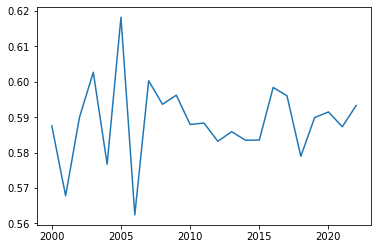

V1_BERIKA


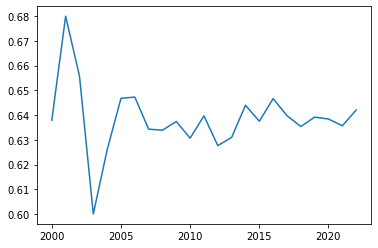

N1_BERIKARE


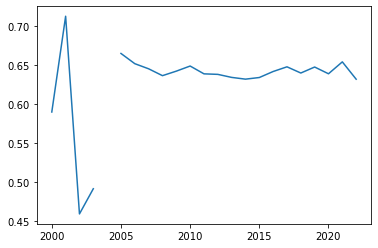

N1_FÖRORTSGÄNG


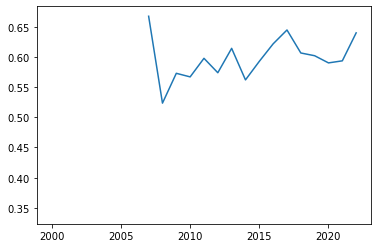

V1_KULTURBERIKA


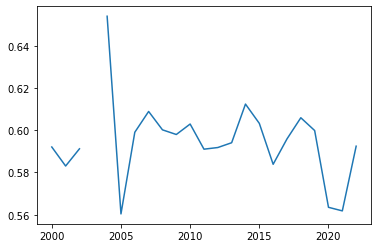

N1C_KULTURBERIKARX


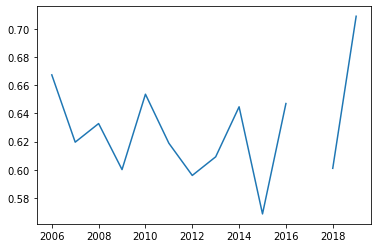

N1_ÅTERVANDRING


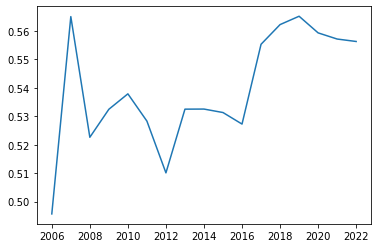

A1_GLOBALISTISK


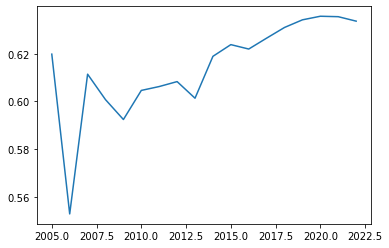

N1_GLOBALIST


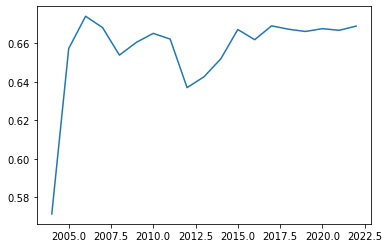

V1_ÅTERVANDRA


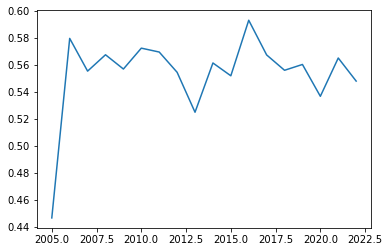

V1_HJÄLPA_PÅ_PLATS


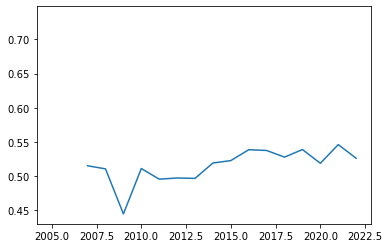

N1C_ÅTERVANDRINGSX


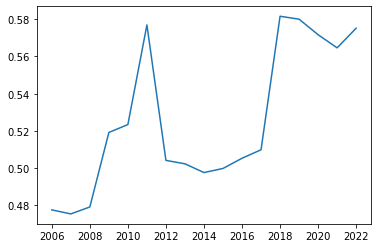

N2_ÅTERVANDRARE


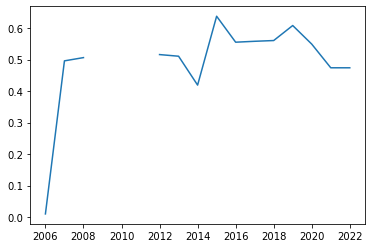

N1C_BERIKAREX


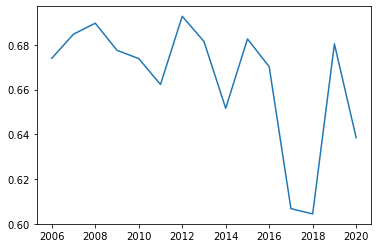

N1C_GLOBALISTX


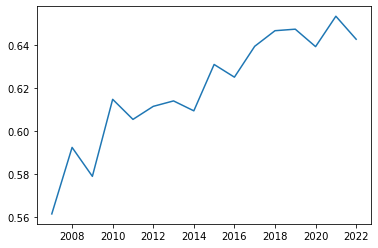

N2C_ÅTERVANDRARX


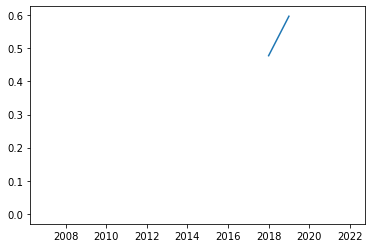

In [135]:
visualize(df_bert_sts, "--ALL", "spr", prefix = ("N", "A", "V"), transition=False)

... the same as z-scores

N1_KULTURBERIKARE


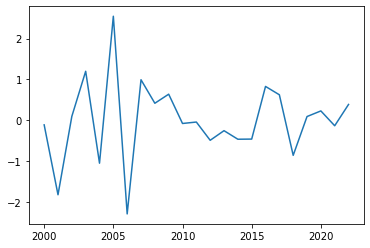

V1_BERIKA


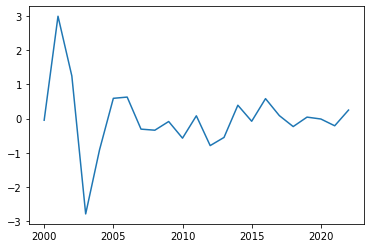

N1_BERIKARE


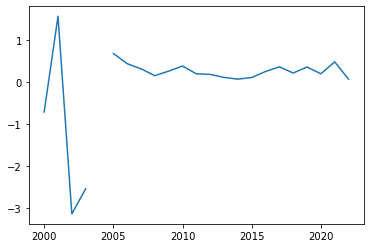

N1_FÖRORTSGÄNG


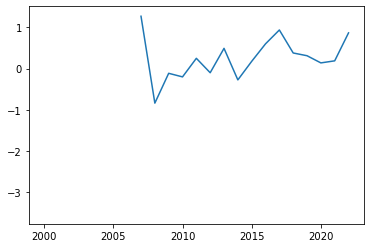

V1_KULTURBERIKA


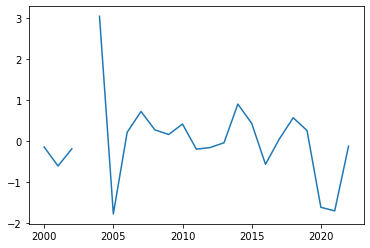

N1C_KULTURBERIKARX


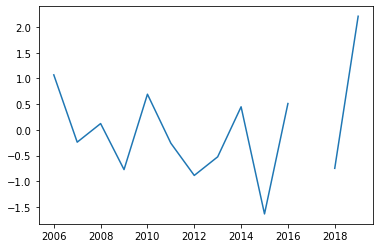

N1_ÅTERVANDRING


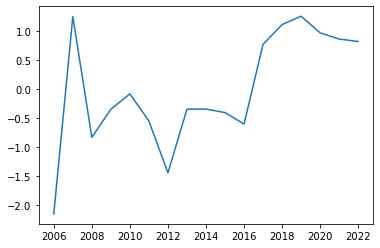

A1_GLOBALISTISK


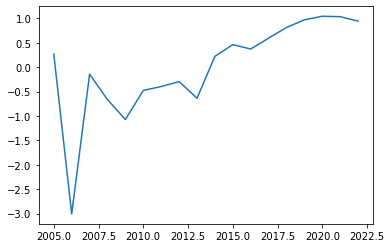

N1_GLOBALIST


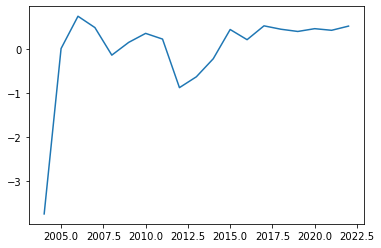

V1_ÅTERVANDRA


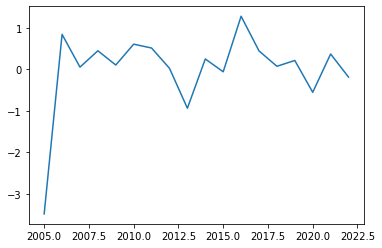

V1_HJÄLPA_PÅ_PLATS


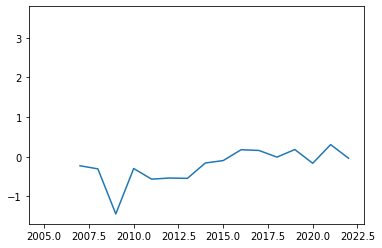

N1C_ÅTERVANDRINGSX


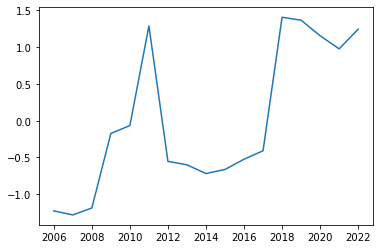

N2_ÅTERVANDRARE


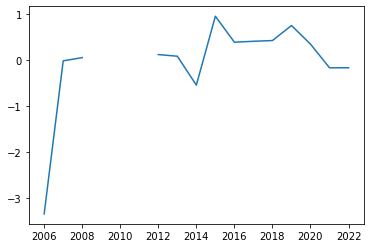

N1C_BERIKAREX


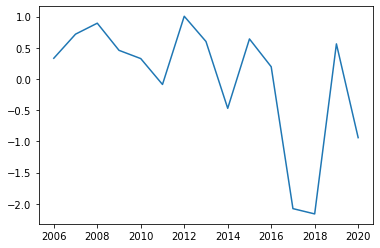

N1C_GLOBALISTX


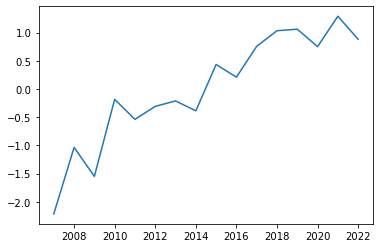

N2C_ÅTERVANDRARX


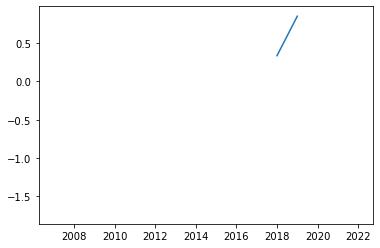

In [89]:
visualize(df_bert_sts, "--ALL", "zscspr", prefix = ("N", "A", "V"), transition=False)

"Anomaly spread" (baiscally the same pattern)

N1_KULTURBERIKARE


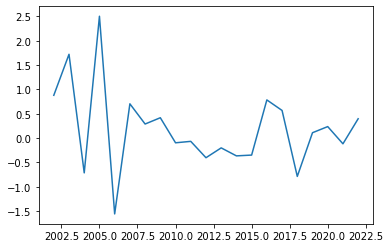

V1_BERIKA


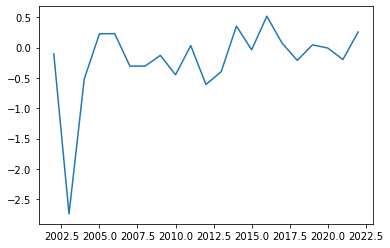

N1_BERIKARE


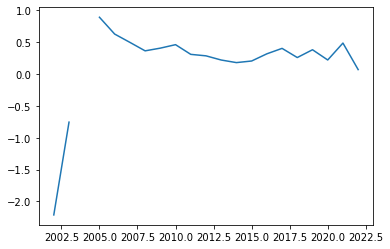

N1_FÖRORTSGÄNG


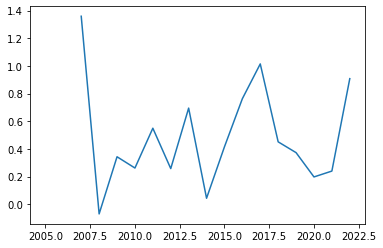

V1_KULTURBERIKA


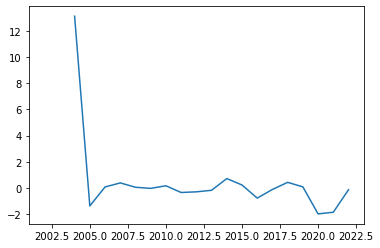

N1C_KULTURBERIKARX


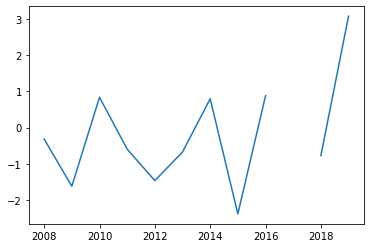

N1_ÅTERVANDRING


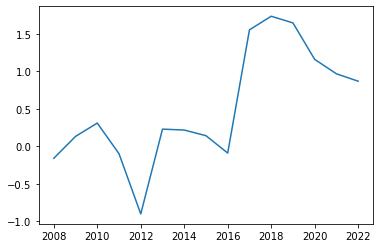

A1_GLOBALISTISK


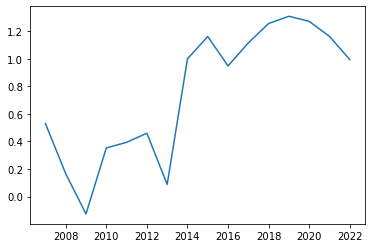

N1_GLOBALIST


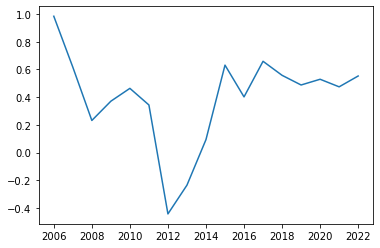

V1_ÅTERVANDRA


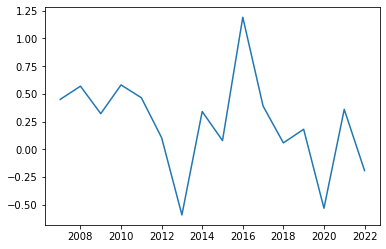

V1_HJÄLPA_PÅ_PLATS


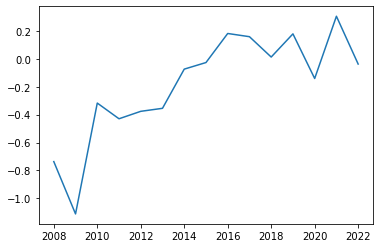

N1C_ÅTERVANDRINGSX


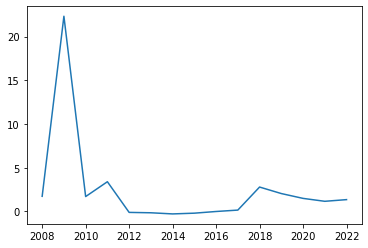

N2_ÅTERVANDRARE


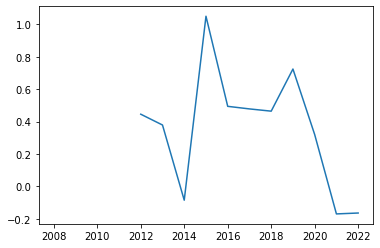

N1C_BERIKAREX


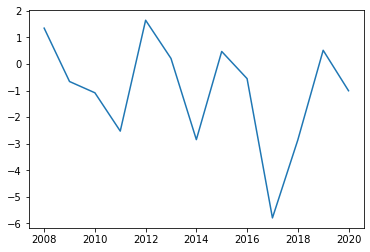

N1C_GLOBALISTX


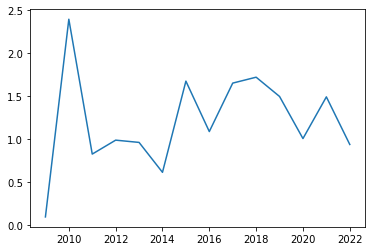

N2C_ÅTERVANDRARX


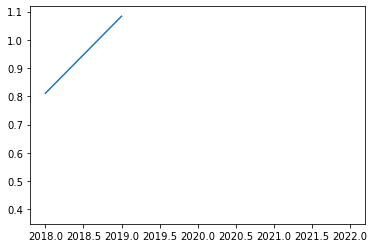

In [88]:
visualize(df_bert_sts, "--ALL", "anospr", prefix = ("N", "A", "V"), transition=False)

in numbers

In [136]:
_ = overview(
    df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
    "anospr", 
    get_dwts(df_bert_sts, dwt_path), 
    th=None, 
    transition = False, 
    min_freq = None, 
    return_md=True, 
    rounder = 2)
print(_)

ANOSPR
                      02    03     04    05    06    07    08     09    10    11    12    13    14    15    16    17    18    19    20    21    22
A1_globalistisk      NaN   NaN    NaN   NaN   NaN  0.53  0.17  -0.13  0.35  0.39  0.46  0.09  1.00  1.16  0.95  1.12  1.26  1.31  1.27  1.16  0.99
N1C_berikareX        NaN   NaN    NaN   NaN   NaN   NaN  1.35  -0.66 -1.08 -2.53  1.65  0.21 -2.85  0.47 -0.55 -5.79 -2.86  0.52 -1.01   NaN   NaN
N1C_globalistX       NaN   NaN    NaN   NaN   NaN   NaN   NaN   0.09  2.40  0.82  0.99  0.96  0.61  1.68  1.09  1.65  1.72  1.50  1.01  1.49  0.94
N1C_kulturberikarX   NaN   NaN    NaN   NaN   NaN   NaN -0.32  -1.61  0.84 -0.59 -1.46 -0.67  0.79 -2.38  0.88   NaN -0.77  3.07   NaN   NaN   NaN
N1C_återvandringsX   NaN   NaN    NaN   NaN   NaN   NaN  1.73  22.32  1.70  3.40 -0.11 -0.16 -0.29 -0.20 -0.01  0.15  2.79  2.04  1.49  1.16  1.35
N1_berikare        -2.21 -0.76    NaN  0.89  0.63  0.50  0.36   0.41  0.46  0.31  0.29  0.22  0.18  0.20  0.32 

In [ ]:
# _ = overview(df_bert_sts, "anospr", get_dwts(df_bert_sts, dwt_path), th=-2, transition = False, min_freq = None, return_md=True, rounder = 2)
# print(_)

In [ ]:
#trend(df_bert_sts, var="anospr", norm=None, transition = False, metric="pearson")

### How is spread related to frequency?

Increase in freq., increase in spread, which makes sense (not a strong correlation though).

In [137]:
universal_correlation(
    df = df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
    var1 = "fpm", 
    var2 = "spr", 
    var1cut = None, 
    var2cut = None,
    prenorm1 = np.log,
    prenorm2 = None,
    norm1=zscore, 
    norm2=zscore, 
    metric="pearson",
    top_n = None,
    min_freq = None
)

Length:
X: 368
Y: 368


(0.2786887820643295, 2.2660167779382577e-06)

N1_kulturberikare


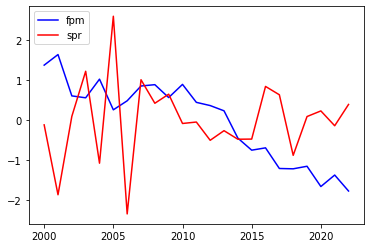

V1_berika


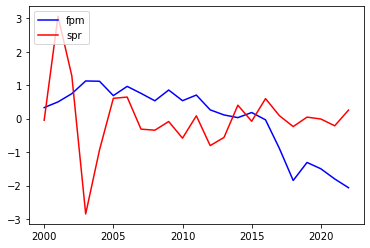

N1_berikare


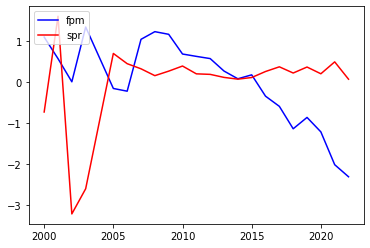

N1_förortsgäng


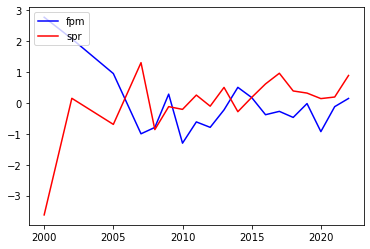

V1_kulturberika


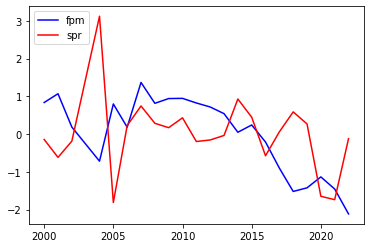

N1C_kulturberikarX


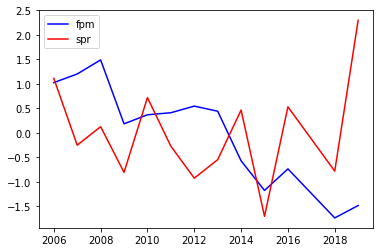

N1_återvandring


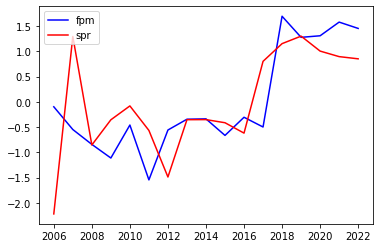

A1_globalistisk


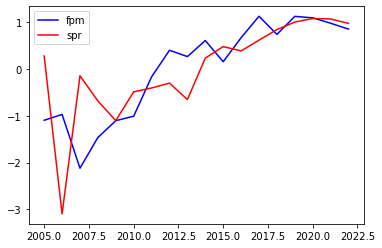

N1_globalist


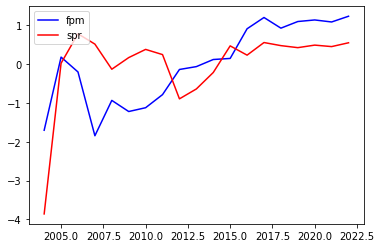

V1_återvandra


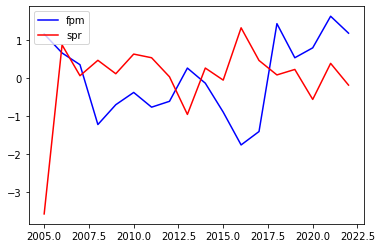

V1_hjälpa_på_plats


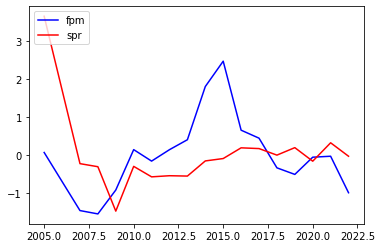

N1C_återvandringsX


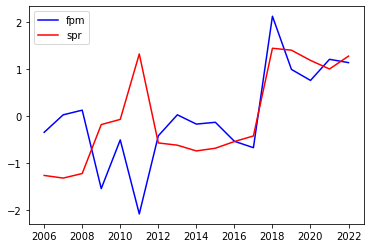

N2_återvandrare


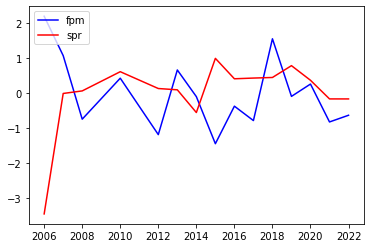

N1C_berikareX


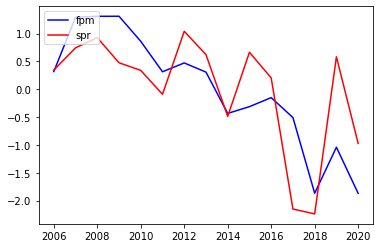

N1C_globalistX


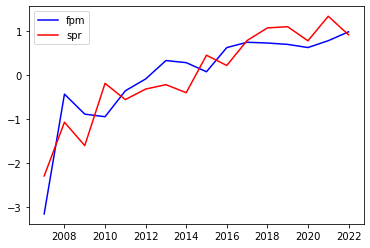

N2C_återvandrarX


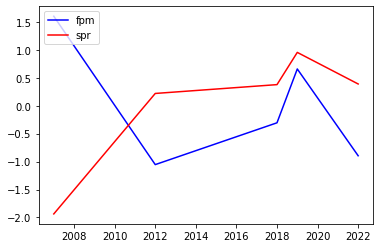

In [138]:
vis_cor(df=df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
        var1="fpm", 
        var1tr = False,
        var2="spr",
        var2tr = False,
        prenorm1=np.log,
        norm1=zscore,
        norm2=zscore
       )

### How is spread related to change?

No. There is no relation.

In [139]:
universal_correlation(
    df = df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
    var1 = "difspr", 
    var2 = "rch", 
    var1cut = None, 
    var2cut = None,
    prenorm1 = None,
    prenorm2 = None,
    norm1=None, 
    norm2=None, 
    metric="spearman",
    top_n = None,
    min_freq = 100
)

Length:
X: 352
Y: 352


(0.037125953871216665, 0.7028572940848796)

## HOW IS MEANING CHANGE RELATED TO FREQUENCY?

Can we confirm a *law of confirmity*?

### Overall (SGNS only)

In [125]:
universal_correlation(
    df=df_yearly, 
    var1="gch", 
    var2="fpm", 
    var1cut = None, 
    var2cut = -1, 
    norm1=None, 
    norm2=None, 
    metric="spearman")

Length:
X: 2230580
Y: 2230580


(0.47189795604723617, 0.0)

In [209]:
universal_correlation(
    df=df_yearly, 
    var1="rch", 
    var2="fpm", 
    var1cut = None, 
    var2cut = -1, 
    norm1=None, 
    norm2=np.log, 
    metric="spearman",
    top_n =10000,
    min_freq = None
)

Length:
X: 220000
Y: 220000


(0.3607390066182087, 0.0)

**Mystery solved!!!!** Hamilton et al only considers the top 10 000 words.

In [129]:
universal_correlation(
    df=df_yearly, 
    var1="gch", 
    var2="fpm", 
    var1cut = None, 
    var2cut = -1, 
    norm1=np.log, 
    norm2=np.log, 
    metric="pearson",
    top_n =10000,
    min_freq = None
)

Length:
X: 220000
Y: 220000


(-0.23119811571455753, 0.0)

In [146]:
universal_correlation(
    #df = df_bert_big.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
    df = df_yearly,
    var1 = "diffpm", 
    var2 = "rch", 
    var1cut = None, 
    var2cut = None, 
    norm1=None, 
    norm2=None,
    top_n = 10000,
    metric="spearman"
)

Length:
X: 220000
Y: 220000


(-0.13009563722425999, 0.0)

In [143]:
universal_correlation(
    df=df_yearly, 
    var1="rch", 
    var2="stdc", 
    var1cut = None, 
    var2cut = None, 
    norm1=None, 
    norm2=None, 
    metric="pearson",
    #top_n = 10000
)

Length:
X: 2230580
Y: 2230580


(0.0528223013427002, 0.0)

For frequent terms, RCH and GCH are pos. correlated

In [220]:
universal_correlation(
    df=df_yearly, 
    var1="rch", 
    var2="gch", 
    var1cut = None, 
    var2cut = None, 
    norm1=None, 
    norm2=None, 
    metric="pearson",
    #top_n = 10000
)

Length:
X: 2230580
Y: 2230580


(0.2903516213701205, 0.0)

In [221]:
universal_correlation(
    df=df_yearly, 
    var1="rch", 
    var2="gch", 
    var1cut = None, 
    var2cut = None, 
    norm1=None, 
    norm2=None, 
    metric="pearson",
    top_n = 10000
)

Length:
X: 220000
Y: 220000


(0.24169090799911352, 0.0)

### DWTs

#### SGNS

Violates the law of confirmity! If anything, the terms change more the more frequenct they become. 

**Genuine change ...**

... cut the last one

In [147]:
universal_correlation(df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
                      "fpm", 
                      "gch", 
                      -1, 
                      norm1=np.log)

Length:
X: 242
Y: 242


(0.3671214066853247, 2.8225710577136623e-06)

... cut the first one

In [148]:
universal_correlation(df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
                      "fpm", 
                      "gch", 
                      0, 
                      norm1=np.log)

Length:
X: 242
Y: 242


(0.525277795888679, 2.67132896199089e-12)

In [194]:
correlation(
    df=df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
    var1="fpm",
    var2="gch", 
    mode=2,
    varcutter=True, # Cuts var1
    prenorm1 = None,
    prenorm2 = None,
    norm1=np.log, 
    norm2=None, 
    metric="pearson"
)

,Word,Correlation,p,N
0,N1_kulturberikare,0.53,0.02,19
1,V1_berika,0.23,0.31,22
2,N1_berikare,0.92,0.00,16
3,N1_globalist,-0.54,0.03,17
4,V1_kulturberika,0.93,0.00,16
5,N1_återvandring,0.46,0.08,15
6,V1_återvandra,0.77,0.00,15
7,A1_globalistisk,0.63,0.02,14
8,V1_hjälpa_på_plats,0.52,0.07,13
9,N1_förortsgäng,0.49,0.33,6


**... rectified change**

In [149]:
universal_correlation(df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
                      "fpm", 
                      "rch", 
                      0, 
                      norm1=np.log)

Length:
X: 242
Y: 242


(0.5754571521818355, 5.884448837079723e-15)

In [195]:
correlation(
    df=df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
    var1="fpm",
    var2="rch", 
    mode=2,
    varcutter=True, # Cuts var1
    prenorm1 = None,
    prenorm2 = None,
    norm1=np.log, 
    norm2=None, 
    metric="pearson"
)

,Word,Correlation,p,N
0,N1_kulturberikare,0.69,0.00,19
1,V1_berika,-0.02,0.94,22
2,N1_berikare,0.72,0.00,16
3,N1_globalist,-0.01,0.97,17
4,V1_kulturberika,0.79,0.00,16
5,N1_återvandring,0.74,0.00,15
6,V1_återvandra,0.40,0.14,15
7,A1_globalistisk,0.33,0.25,14
8,V1_hjälpa_på_plats,0.19,0.54,13
9,N1_förortsgäng,0.30,0.56,6


Strong pos. correl. for RCH and GCH

In [224]:
universal_correlation(df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
                      "gch", 
                      "rch", 
                      min_freq=10
                     )

Length:
X: 242
Y: 242


(0.6712088750448056, 1.6456355771053618e-21)

In [225]:
universal_correlation(df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
                      "gch", 
                      "rch", 
                      min_freq=100
                     )

Length:
X: 242
Y: 242


(0.365821569013243, 0.0003357850484445304)

... but it is related to frequency. The postive correlation disapears ehn considering only the most frequent (no relation).

In [157]:
universal_correlation(df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:], 
                      "fpm", 
                      "rch", 
                      0, 
                      norm1=np.log,
                      min_freq=1000
                     )

transitions [('2000', '2001'), ('2001', '2002'), ('2002', '2003'), ('2003', '2004'), ('2004', '2005'), ('2005', '2006'), ('2006', '2007'), ('2007', '2008'), ('2008', '2009'), ('2009', '2010'), ('2010', '2011'), ('2011', '2012'), ('2012', '2013'), ('2013', '2014'), ('2014', '2015'), ('2015', '2016'), ('2016', '2017'), ('2017', '2018'), ('2018', '2019'), ('2019', '2020'), ('2020', '2021'), ('2021', '2022')]
Length:
X: 242
Y: 242


(-0.07463078298581292, 0.7613970313740807)

... considering difference (note: spearman and no log; cannot do logs on negative numbers)

In [196]:
universal_correlation(
    #df = df_bert_big.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
    df = df_yearly_dwt.loc[[w for w in df_yearly_dwt.index if w.startswith(("N", "A", "V"))],:],
    var1 = "diffpm", 
    var2 = "rch", 
    var1cut = None, 
    var2cut = None, 
    norm1=None, 
    norm2=None, 
    metric="spearman"
)

Length:
X: 242
Y: 242


(-0.20968645522725224, 0.00905363350149355)

... rectified change

##### STS (small)

Confirms *law of confirmity* for GCH. The effect disappears with RCH; compare Duborssarsky.

**Genuine** (law of confirmity confirmed)

cut first

In [202]:
universal_correlation(df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
                      "fpm", 
                      "gch", 
                      0, 
                      norm1=np.log,
                      min_freq = 10
                     )

transitions [('2000', '2001'), ('2001', '2002'), ('2002', '2003'), ('2003', '2004'), ('2004', '2005'), ('2005', '2006'), ('2006', '2007'), ('2007', '2008'), ('2008', '2009'), ('2009', '2010'), ('2010', '2011'), ('2011', '2012'), ('2012', '2013'), ('2013', '2014'), ('2014', '2015'), ('2015', '2016'), ('2016', '2017'), ('2017', '2018'), ('2018', '2019'), ('2019', '2020'), ('2020', '2021'), ('2021', '2022')]
Length:
X: 352
Y: 352


(-0.48717520567792927, 2.2363734835654778e-13)

cut last

In [201]:
universal_correlation(df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
                      "fpm", 
                      "gch", 
                      -1, 
                      norm1=np.log,
                      min_freq = 10
                     )

transitions [('2000', '2001'), ('2001', '2002'), ('2002', '2003'), ('2003', '2004'), ('2004', '2005'), ('2005', '2006'), ('2006', '2007'), ('2007', '2008'), ('2008', '2009'), ('2009', '2010'), ('2010', '2011'), ('2011', '2012'), ('2012', '2013'), ('2013', '2014'), ('2014', '2015'), ('2015', '2016'), ('2016', '2017'), ('2017', '2018'), ('2018', '2019'), ('2019', '2020'), ('2020', '2021'), ('2021', '2022')]
Length:
X: 352
Y: 352


(-0.4942501508608941, 8.877718985027028e-14)

In [200]:
correlation(df=df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
            var1="fpm", 
            var2="gch", 
            varcutter=True,
            norm1 = np.log,
            mode=2, 
            metric = "pearson")

,Word,Correlation,p,N
0,N1_kulturberikare,0.40,0.06,22
1,V1_berika,0.44,0.04,22
2,N1_berikare,0.17,0.47,20
3,N1_förortsgäng,-0.43,0.11,15
4,V1_kulturberika,0.11,0.64,20
5,N1C_kulturberikarX,-0.57,0.03,14
6,N1_återvandring,-0.67,0.00,16
7,A1_globalistisk,-0.86,0.00,17
8,N1_globalist,-0.57,0.01,20
9,V1_återvandra,0.05,0.84,18


N1_kulturberikare


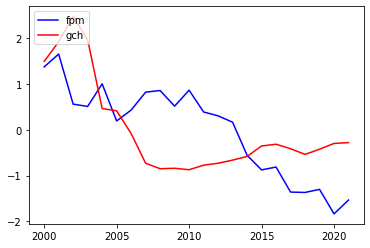

V1_berika


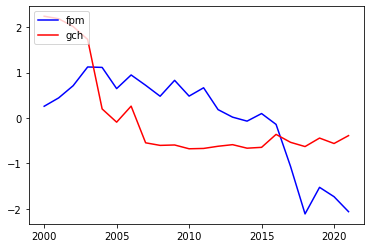

N1_berikare


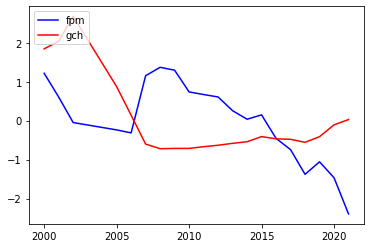

N1_förortsgäng


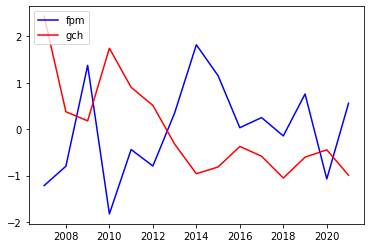

V1_kulturberika


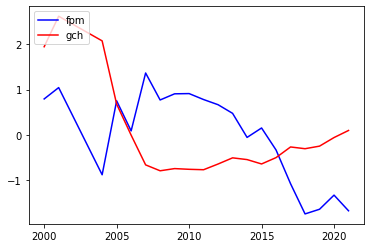

N1C_kulturberikarX


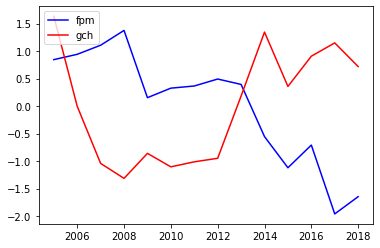

N1_återvandring


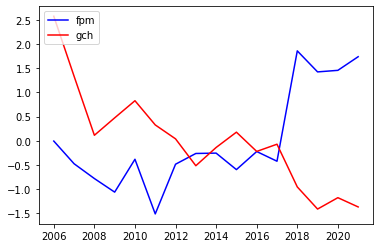

A1_globalistisk


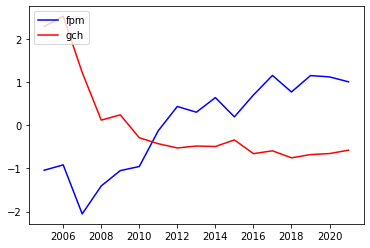

N1_globalist


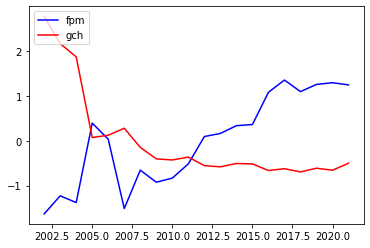

V1_återvandra


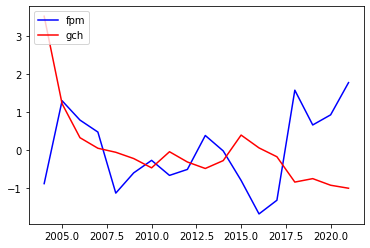

V1_hjälpa_på_plats


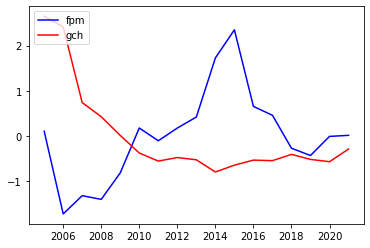

N1C_återvandringsX


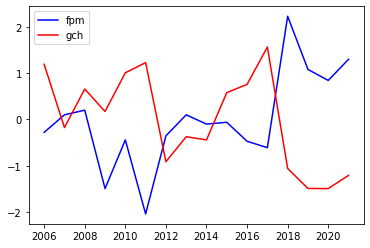

N2_återvandrare


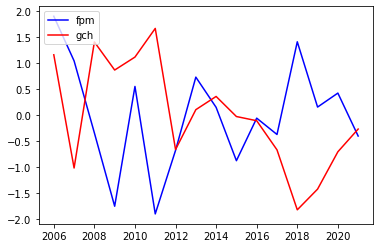

N1C_berikareX


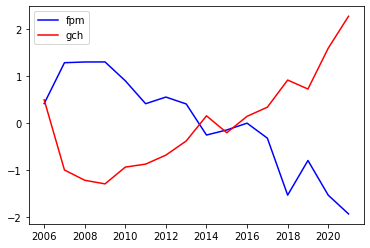

N1C_globalistX


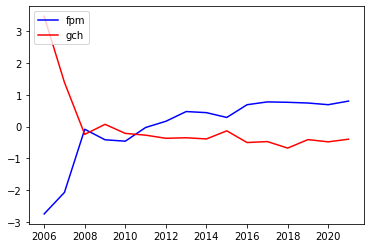

N2C_återvandrarX


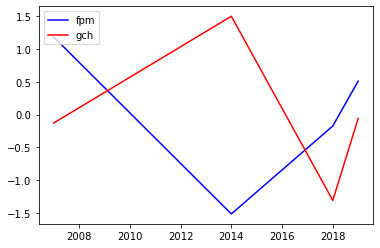

In [207]:
vis_cor(df=df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
            var1="fpm", 
            var1tr = False,
            var2="gch",
            prenorm1=np.log,
            norm1=zscore,
            norm2=zscore
       )

**Rectified** (opposite relationship: positive correlation; if at all)

In [204]:
universal_correlation(df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
                      "fpm", 
                      "rch", 
                      0, 
                      norm1=np.log,
                      min_freq = 10
                     )

transitions [('2000', '2001'), ('2001', '2002'), ('2002', '2003'), ('2003', '2004'), ('2004', '2005'), ('2005', '2006'), ('2006', '2007'), ('2007', '2008'), ('2008', '2009'), ('2009', '2010'), ('2010', '2011'), ('2011', '2012'), ('2012', '2013'), ('2013', '2014'), ('2014', '2015'), ('2015', '2016'), ('2016', '2017'), ('2017', '2018'), ('2018', '2019'), ('2019', '2020'), ('2020', '2021'), ('2021', '2022')]
Length:
X: 352
Y: 352


(0.5287682425122272, 7.114328396385104e-16)

cut last

In [205]:
universal_correlation(df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
                      "fpm", 
                      "rch", 
                      -1, 
                      norm1=np.log,
                      min_freq = 10
                     )

transitions [('2000', '2001'), ('2001', '2002'), ('2002', '2003'), ('2003', '2004'), ('2004', '2005'), ('2005', '2006'), ('2006', '2007'), ('2007', '2008'), ('2008', '2009'), ('2009', '2010'), ('2010', '2011'), ('2011', '2012'), ('2012', '2013'), ('2013', '2014'), ('2014', '2015'), ('2015', '2016'), ('2016', '2017'), ('2017', '2018'), ('2018', '2019'), ('2019', '2020'), ('2020', '2021'), ('2021', '2022')]
Length:
X: 352
Y: 352


(0.38753540213988197, 1.3183389681637401e-08)

In [206]:
correlation(df=df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
            var1="fpm", 
            var2="rch", 
            varcutter=True,
            norm1 = np.log,
            mode=2, 
            metric = "pearson")

,Word,Correlation,p,N
0,N1_kulturberikare,0.50,0.02,22
1,V1_berika,0.23,0.31,22
2,N1_berikare,0.66,0.00,20
3,N1_förortsgäng,0.28,0.32,15
4,V1_kulturberika,0.13,0.58,20
5,N1C_kulturberikarX,0.48,0.08,14
6,N1_återvandring,0.55,0.03,16
7,A1_globalistisk,0.47,0.05,17
8,N1_globalist,0.76,0.00,20
9,V1_återvandra,0.57,0.01,18


N1_kulturberikare


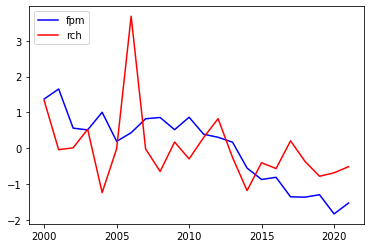

V1_berika


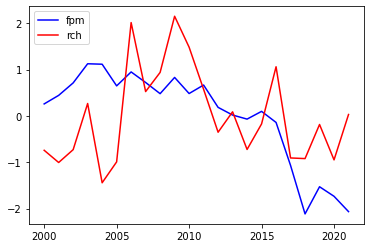

N1_berikare


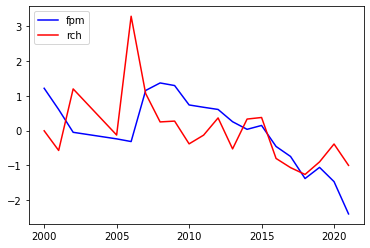

N1_förortsgäng


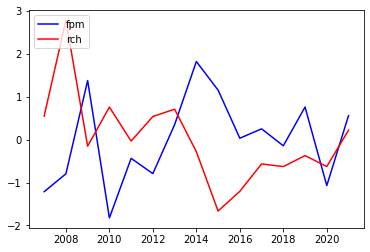

V1_kulturberika


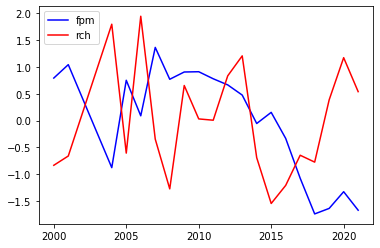

N1C_kulturberikarX


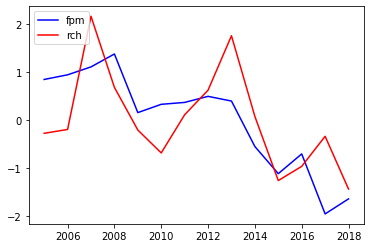

N1_återvandring


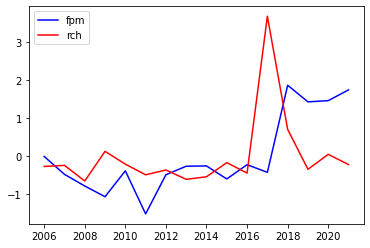

A1_globalistisk


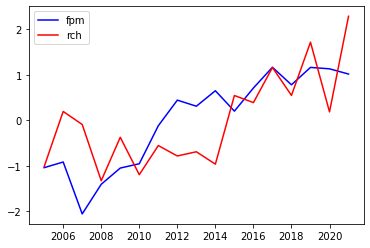

N1_globalist


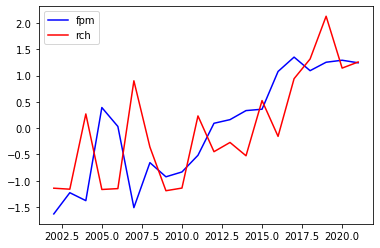

V1_återvandra


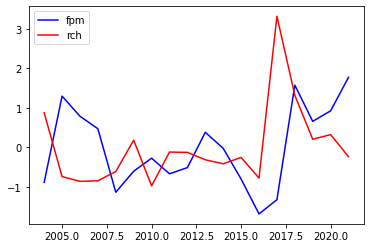

V1_hjälpa_på_plats


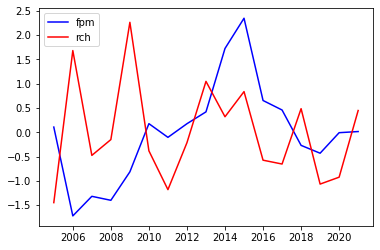

N1C_återvandringsX


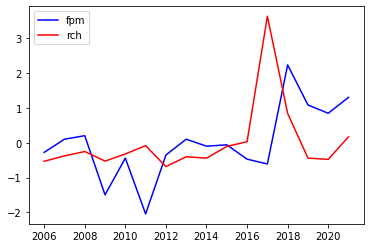

N2_återvandrare


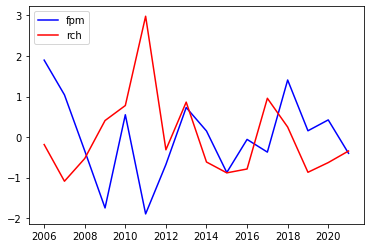

N1C_berikareX


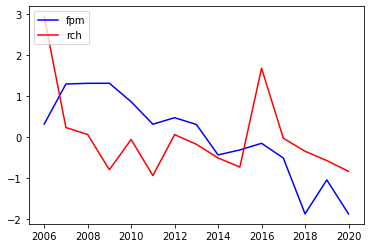

N1C_globalistX


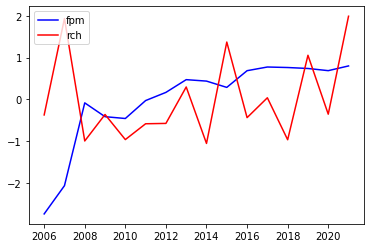

N2C_återvandrarX


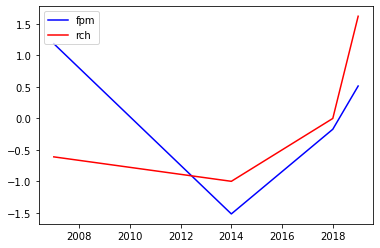

In [203]:
vis_cor(df=df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
            var1="fpm", 
            var1tr = False,
            var2="rch",
            prenorm1=np.log,
            norm1=zscore,
            norm2=zscore
       )

The smaller the standard deviation, the larger RCH

In [218]:
universal_correlation(df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
                      "stdc", 
                      "rch", 
                      norm1=None,
                      min_freq = 100
                     )

Length:
X: 352
Y: 352


(-0.5886484177614424, 2.0839825934690765e-11)

The smaller the control mean, the larger RCH

In [217]:
universal_correlation(df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
                      "mccc", 
                      "rch", 
                      norm1=None,
                      min_freq = 100
                     )

Length:
X: 352
Y: 352


(-0.6057526994771587, 3.766984757274256e-12)

RCH and GCH are poorly correlated

In [212]:
universal_correlation(df_bert_sts.loc[[w for w in df_bert_sts.index if w.startswith(("N", "A", "V"))],:], 
                      "gch", 
                      "rch", 
                      norm1=None,
                      min_freq = 10
                     )

Length:
X: 352
Y: 352


(-0.1658844078106383, 0.018598664475348282)